# CRE/MF Mortgage Rate Model On-ValidMind

# Setup

In [1]:
# Quick hack to load local library code
import os
os.chdir(os.path.join(os.getcwd(), ".."))
# Load API key and secret from environment variables
from dotenv import load_dotenv
load_dotenv()

# ML libraries
import pandas as pd
import xgboost as xgb
from numpy import argmax
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split

# ValidMind libraries 
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split
import validmind as vm
from validmind.vm_models.test_context import TestContext

# Plotting libraries 
import matplotlib.pyplot as plt
%matplotlib inline


# Load Data

In [2]:
df = pd.read_csv("/Users/juanvalidmind/Dev/github/validmind/validmind-python/notebooks/datasets/lending_club_loan_rates.csv", sep='\t')
df = df.rename(columns={'Unnamed: 0': 'Date'})
df = df.set_index(pd.to_datetime(df['Date']))
df.drop(["Date"], axis=1, inplace=True)
df.head()

,loan_rate_A,loan_rate_B,loan_rate_C,loan_rate_D,FEDFUNDS,diff1_loan_rate_A,diff1_loan_rate_B,diff1_loan_rate_C,diff1_loan_rate_D,diff1_FEDFUNDS,diff2_FEDFUNDS
Date,,,,,,,,,,,
2007-08-01,7.766667,9.497692,10.947500,12.267000,5.02,0.060000,0.134359,0.207500,-0.467444,-0.24,-0.25
2007-09-01,7.841429,9.276667,10.829167,12.436667,4.94,0.074762,-0.221026,-0.118333,0.169667,-0.08,0.16
2007-10-01,7.830000,9.433333,10.825926,12.737368,4.76,-0.011429,0.156667,-0.003241,0.300702,-0.18,-0.10
2007-11-01,7.779091,9.467778,10.967037,12.609444,4.49,-0.050909,0.034444,0.141111,-0.127924,-0.27,-0.09
2007-12-01,7.695833,9.387500,10.805000,12.478889,4.24,-0.083258,-0.080278,-0.162037,-0.130556,-0.25,0.02


Remove diff columns.

In [3]:
columns_to_remove = [col for col in df.columns if col.startswith("diff")]
df = df.drop(columns=columns_to_remove)

Visual Inspection.

# ValidMind Setup

Initialize ValidMind dataset.

In [4]:
vm.init(
  api_host = "http://localhost:3000/api/v1/tracking",
  api_key = "e22b89a6b9c2a27da47cb0a09febc001",
  api_secret = "a61be901b5596e3c528d94231e4a3c504ef0bb803d16815f8dfd6857fac03e57",
  project = "clgo0g0rt0000fjy6ozl9pb69"
)

True

In [5]:
target_variables = ["loan_rate_A", "loan_rate_B", "loan_rate_C", "loan_rate_D"]

vm_dataset = vm.init_dataset(
    dataset=df,
    target_column = target_variables   
)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


Create Train and Test datasets.

In [6]:
test_size = 30
train_ds = df[:-test_size]
test_ds = df[-test_size:]

vm_train_ds = vm.init_dataset(dataset=train_ds, type="generic", target_column=target_variables)
vm_test_ds = vm.init_dataset(dataset=test_ds, type="generic", target_column=target_variables)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...
Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


Visualize existing test plans.

In [7]:
vm.test_plans.list_plans()

ID,Name,Description
sklearn_classifier_metrics,SKLearnClassifierMetrics,Test plan for sklearn classifier metrics
sklearn_classifier_validation,SKLearnClassifierPerformance,Test plan for sklearn classifier models
sklearn_classifier,SKLearnClassifier,Test plan for sklearn classifier models that includes both metrics and validation tests
tabular_dataset,TabularDataset,Test plan for generic tabular datasets
tabular_dataset_description,TabularDatasetDescription,Test plan to extract metadata and descriptive statistics from a tabular dataset
tabular_data_quality,TabularDataQuality,Test plan for data quality on tabular datasets
normality_test_plan,NormalityTestPlan,Test plan to perform normality tests.
autocorrelation_test_plan,AutocorrelationTestPlan,Test plan to perform autocorrelation tests.
seasonality_test_plan,SesonalityTestPlan,Test plan to perform seasonality tests.
unit_root_test_plan,UnitRootTestPlan,Test plan to perform unit root tests.


# 4. Model Development

# 4.1. Development Data and Platform

## 4.1.2. Data Quality and Relevance

## 4.1.3. Data Process, Adjustments and Treatment

## A. Missing Values Analysis

**Step 1: Calculate the percentage of missing values in each column**

**Step 2: Display the missing values percentage in a table format**

**Step 3: Visualize the missing values**

 ## B. Outliers Analysis

**Step 1: Visualize the dataset using box plots**

Visualize the data using box plots to get an initial sense of the presence of outliers.

**Step 2: Calculate Z-scores**

**Step 3: Set a threshold and identify outliers**

Set a threshold (e.g., 3) to identify data points with Z-scores higher than the threshold.

**Step 4: Analyze the outliers**

Analyze the outliers by looking at their frequency, index, and corresponding column.

## C. Seasonality Analysis

**Step 1: Seasonal decomposition**

Perform seasonal decomposition on each time series.

In [8]:
from validmind.model_validation.statsmodels.metrics import SeasonalDecompose
test_context = TestContext(train_ds=vm_train_ds)
sd_metric = SeasonalDecompose(test_context=test_context)

**Step 2: Visualize seasonal decomposition**

Create plots for observed, trend, seasonal and residual components.


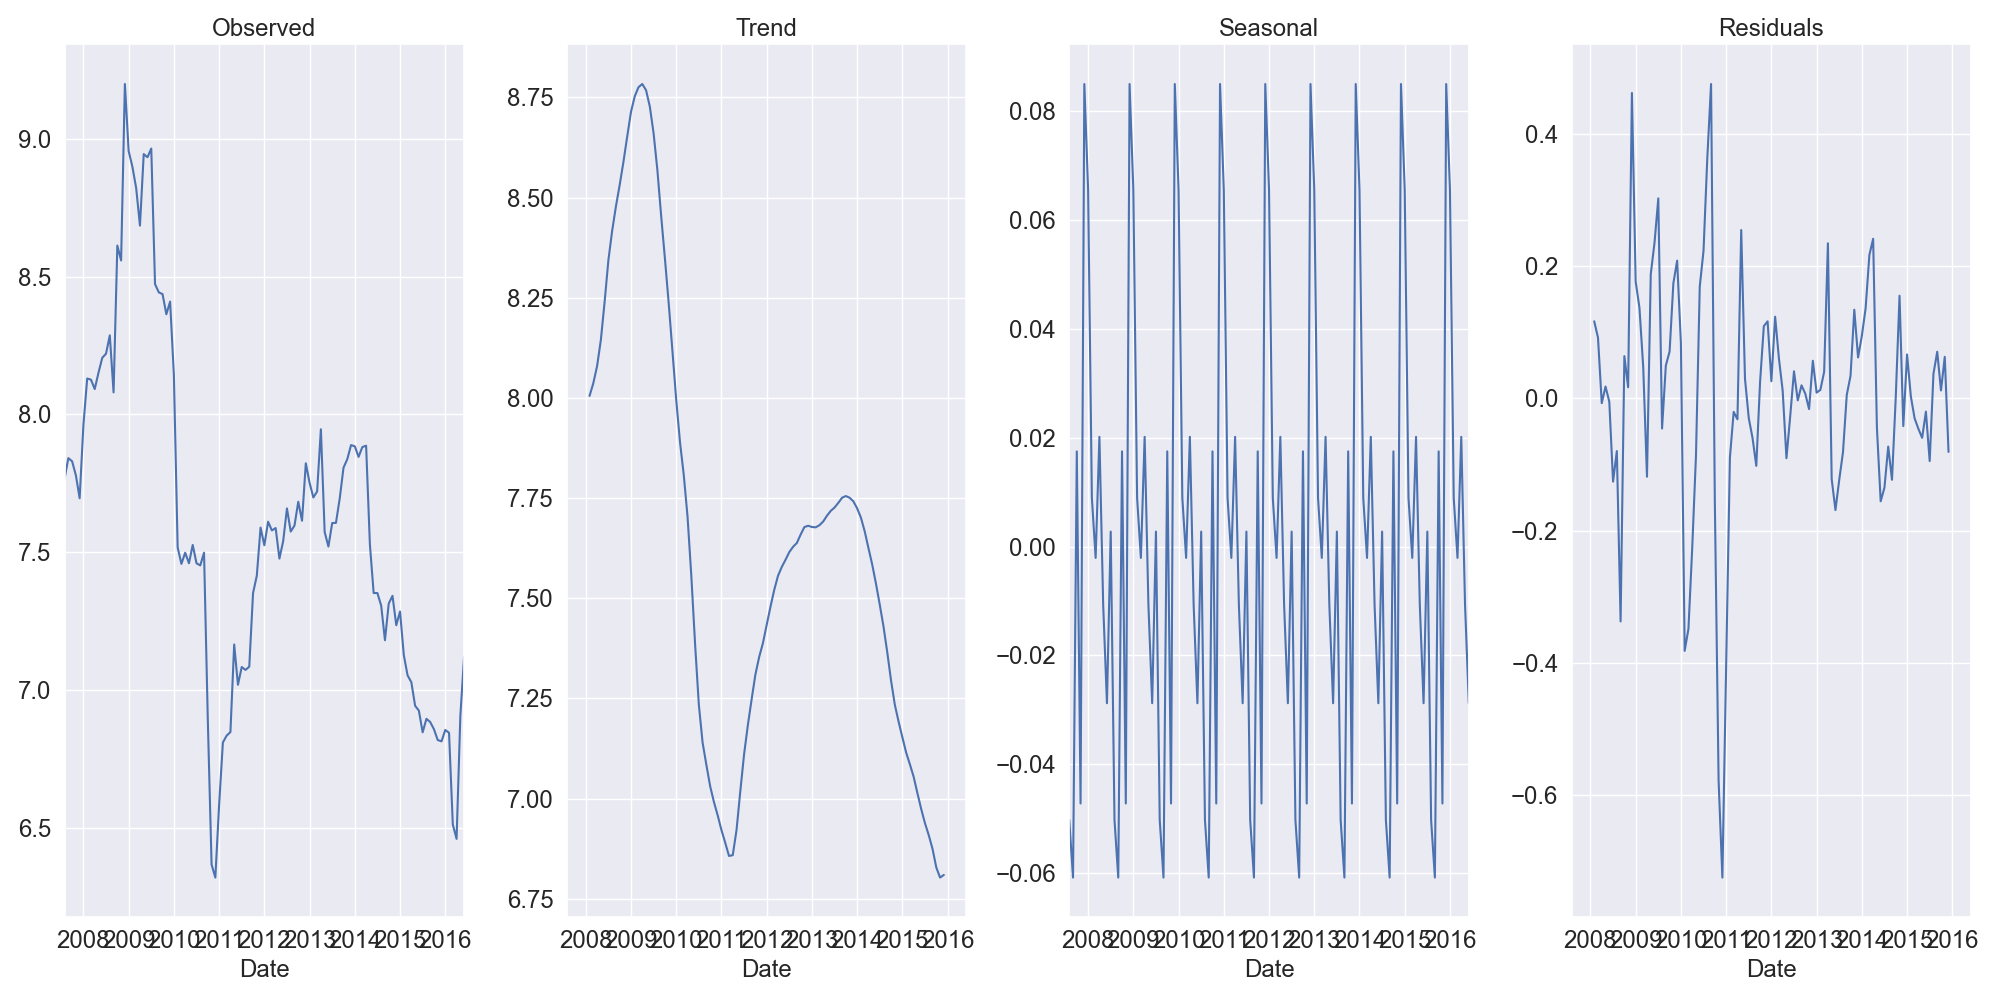
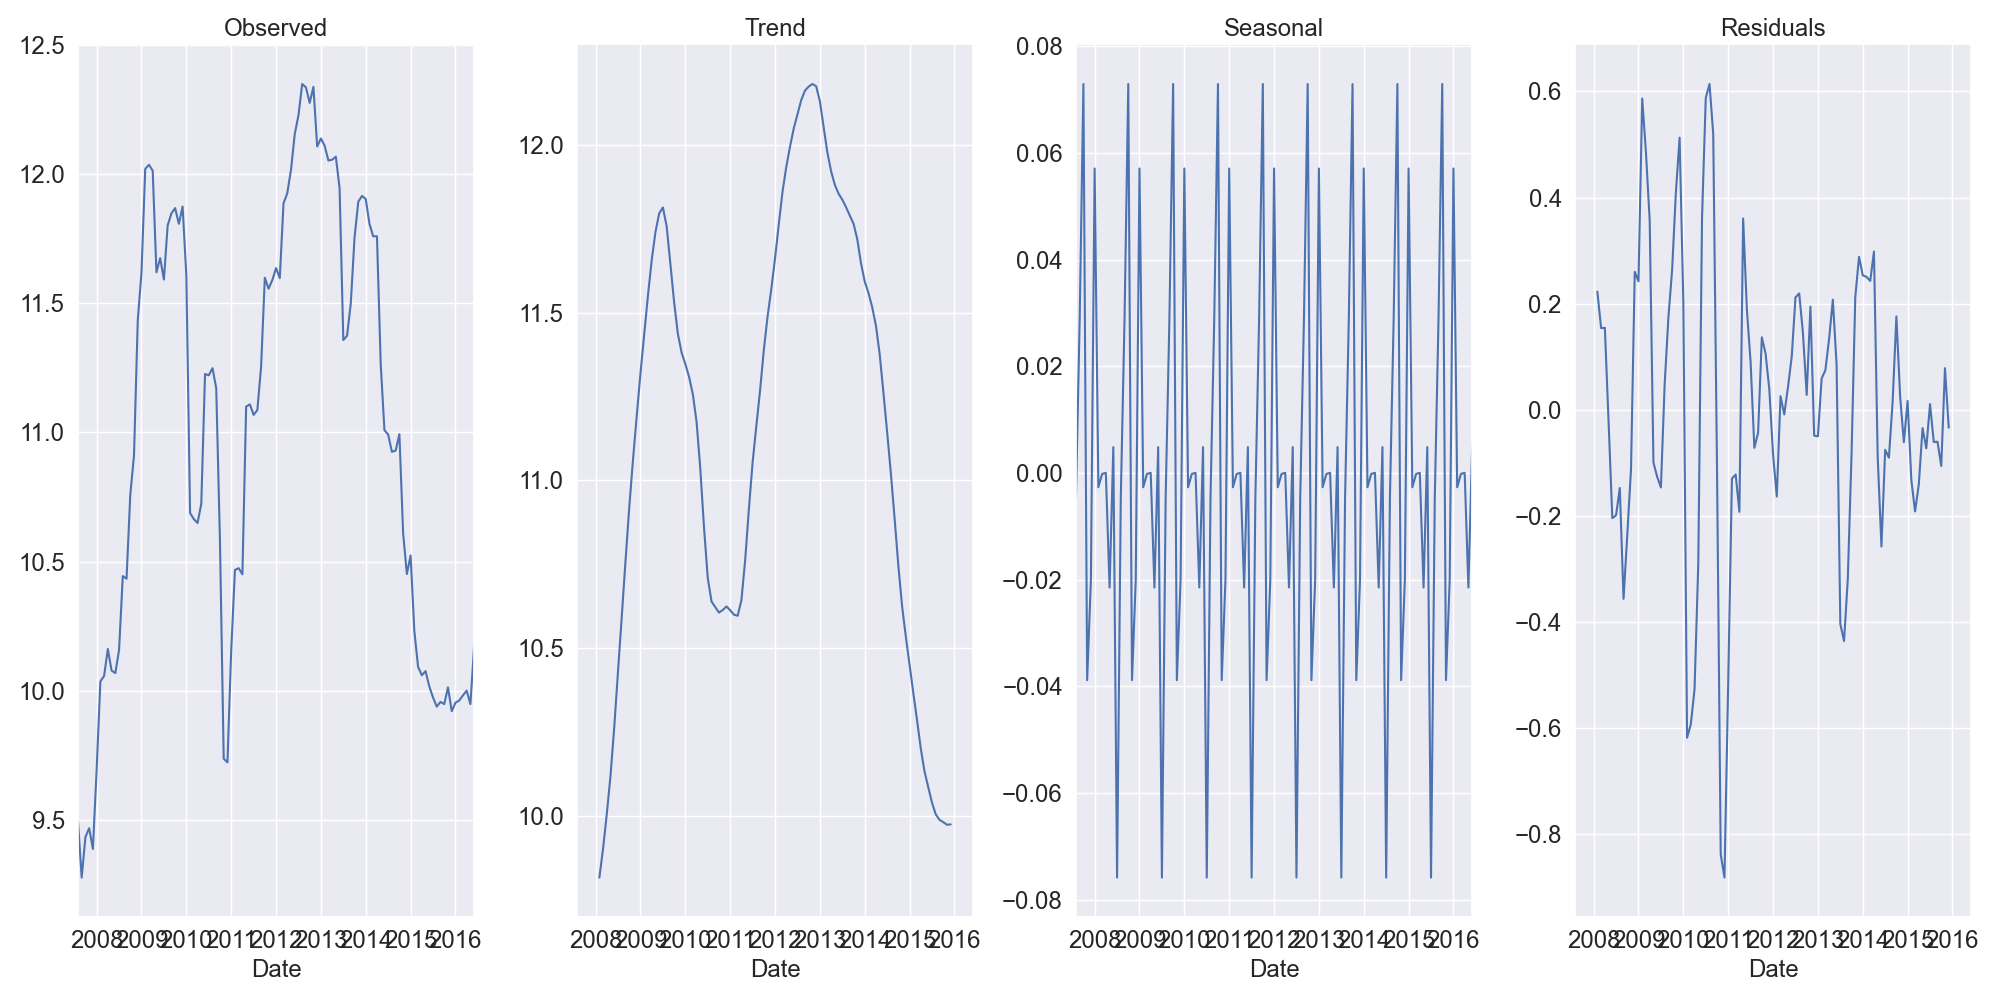
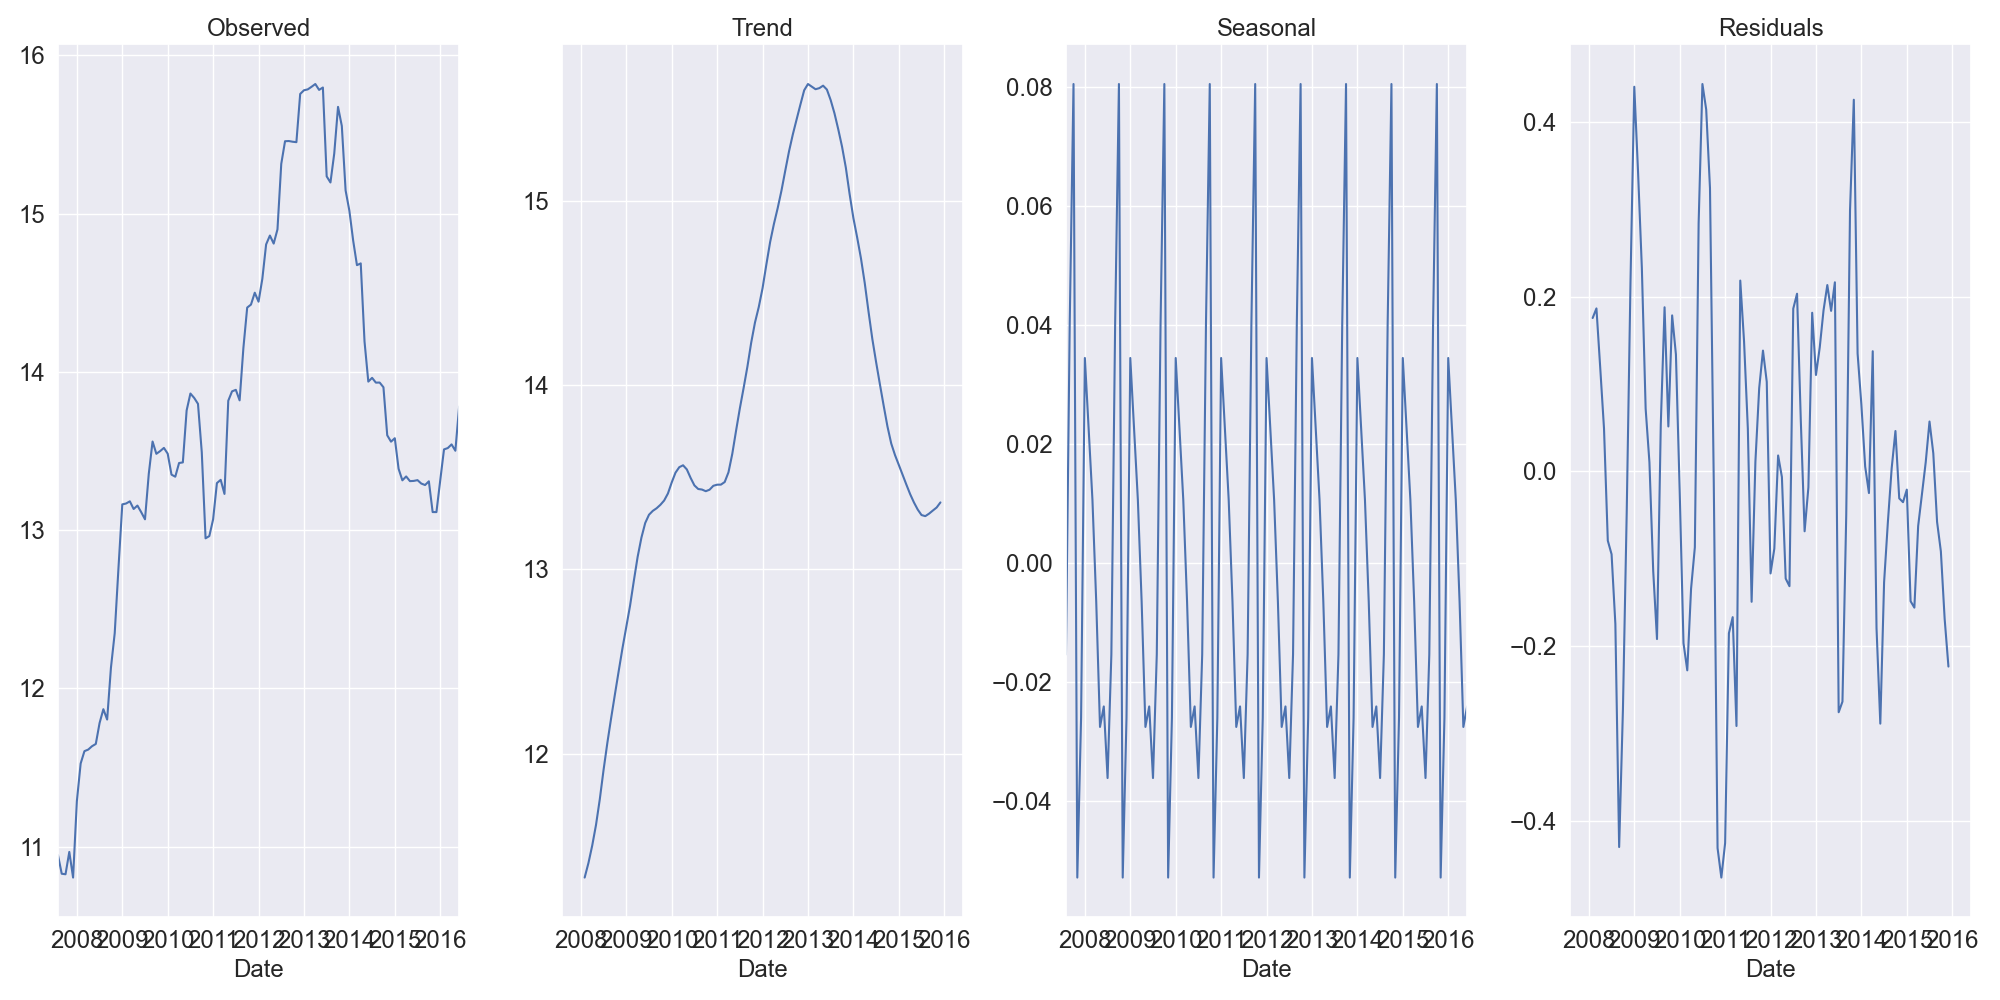
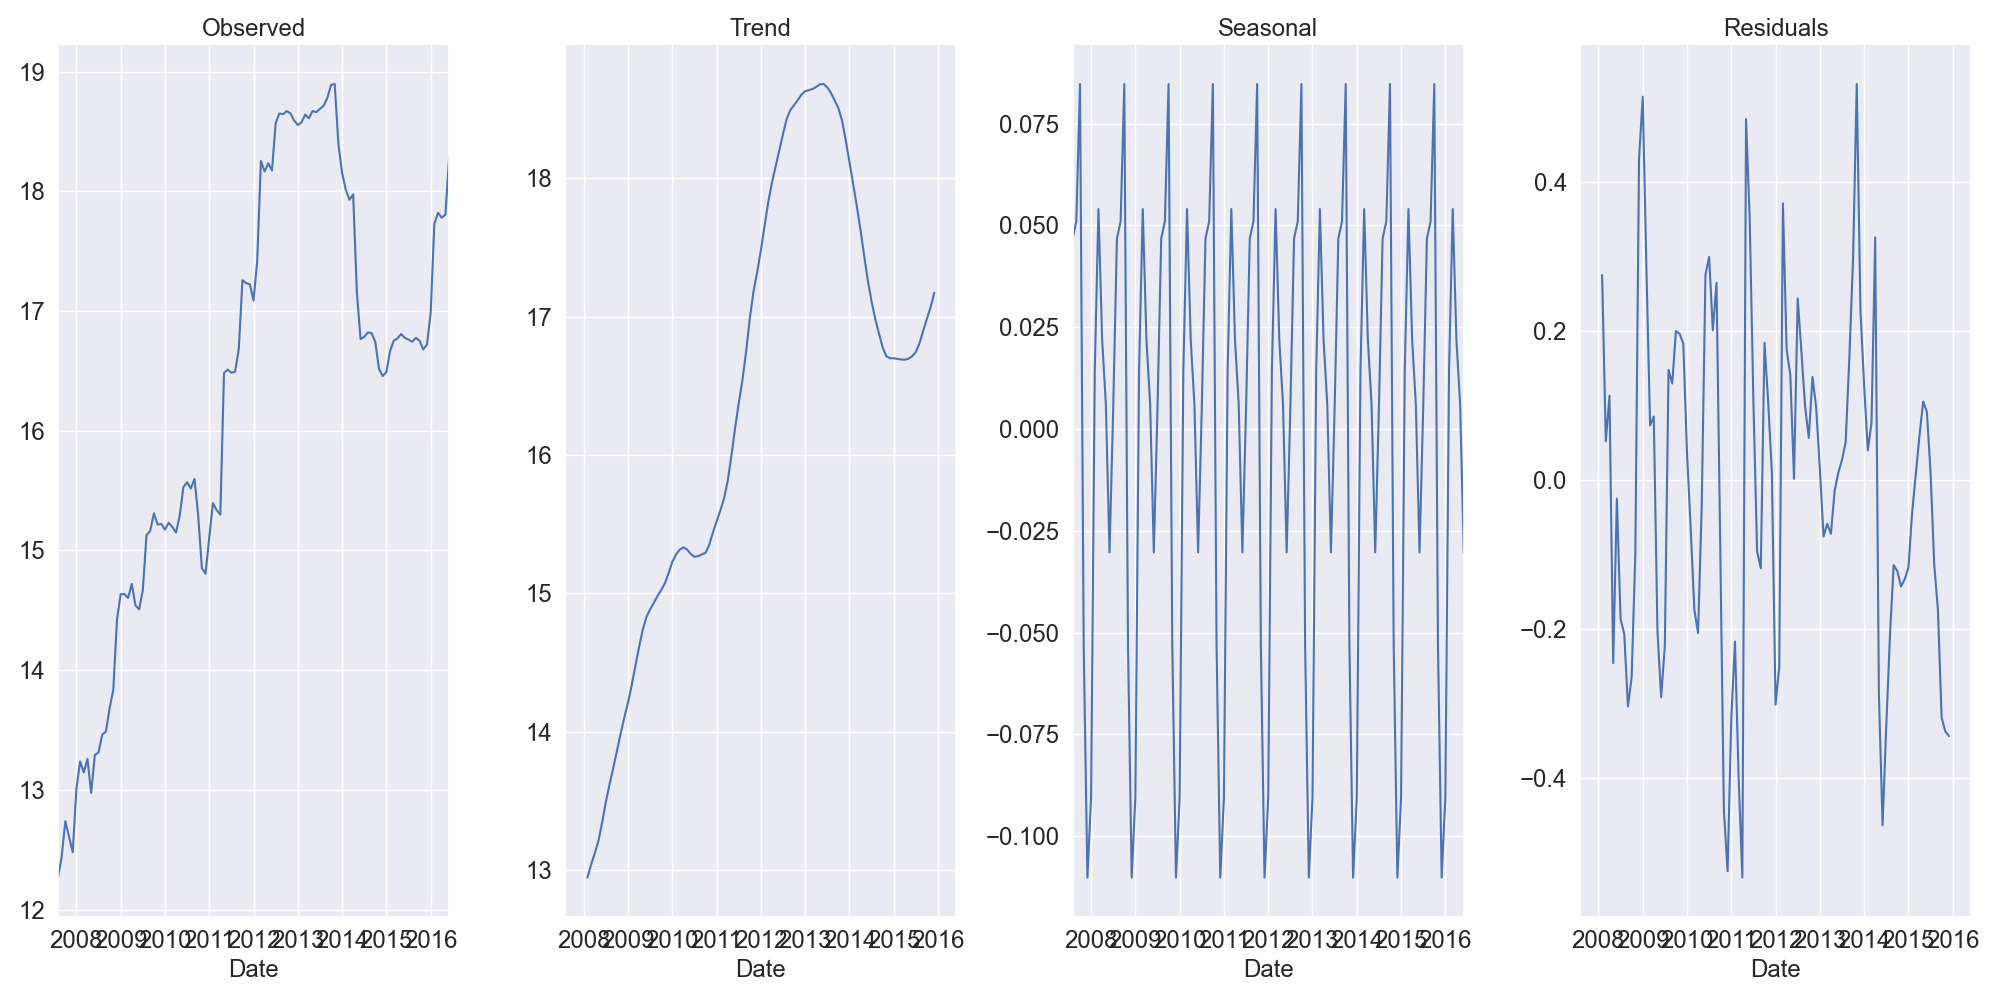
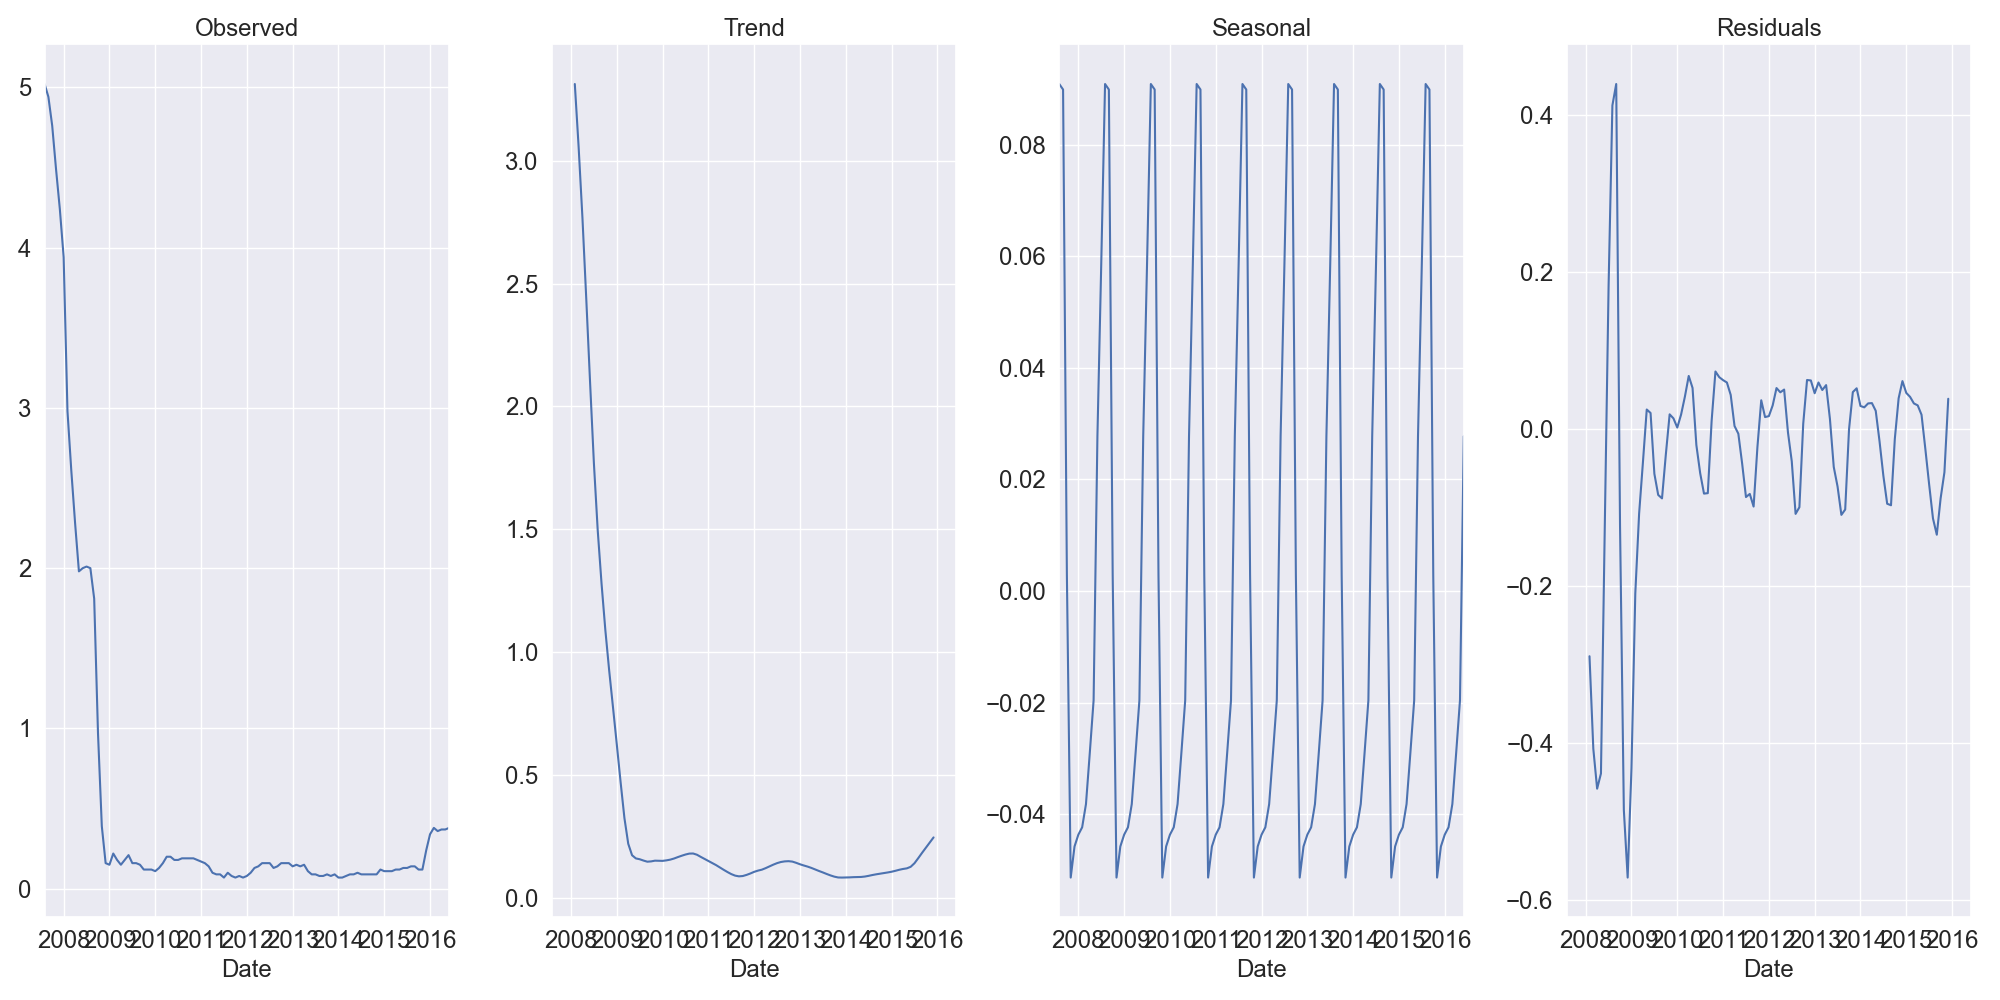

In [9]:
sd_metric.run()
sd_metric.result.show()

Seasonality Detection using ACF and PACF.

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



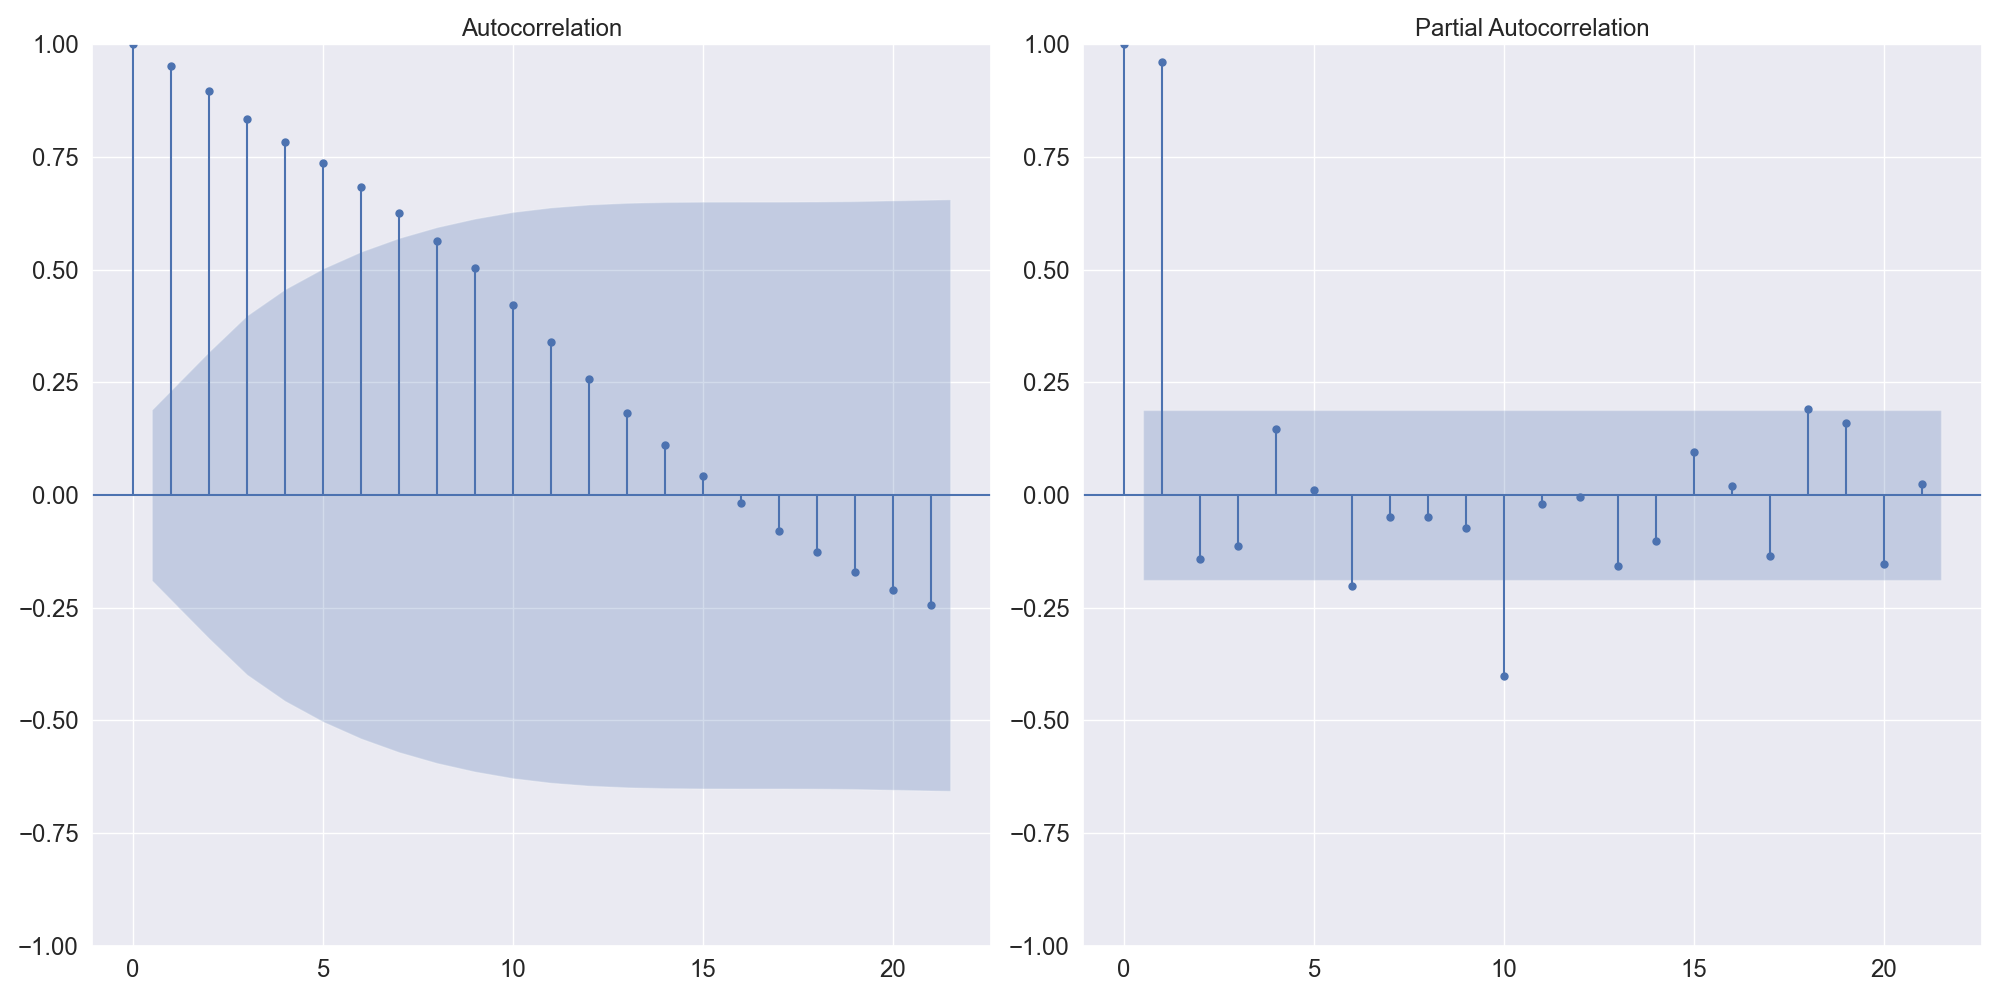
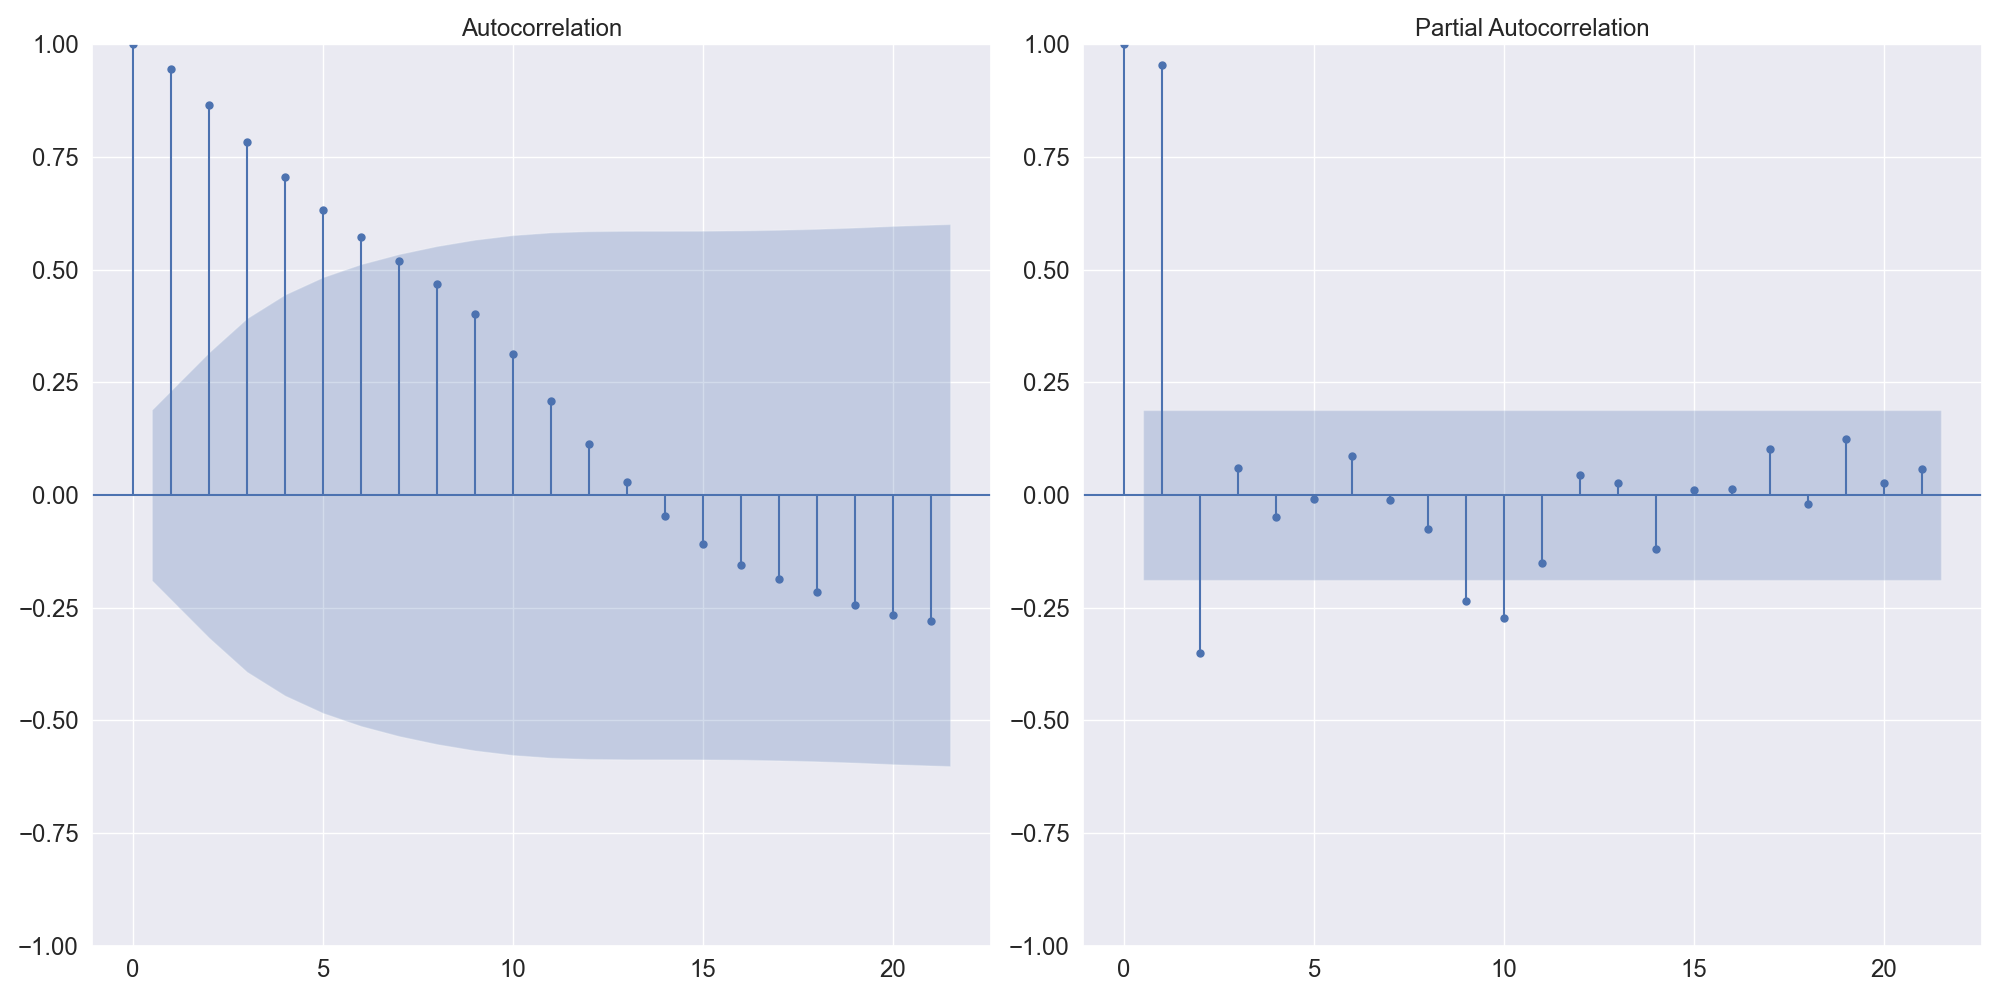
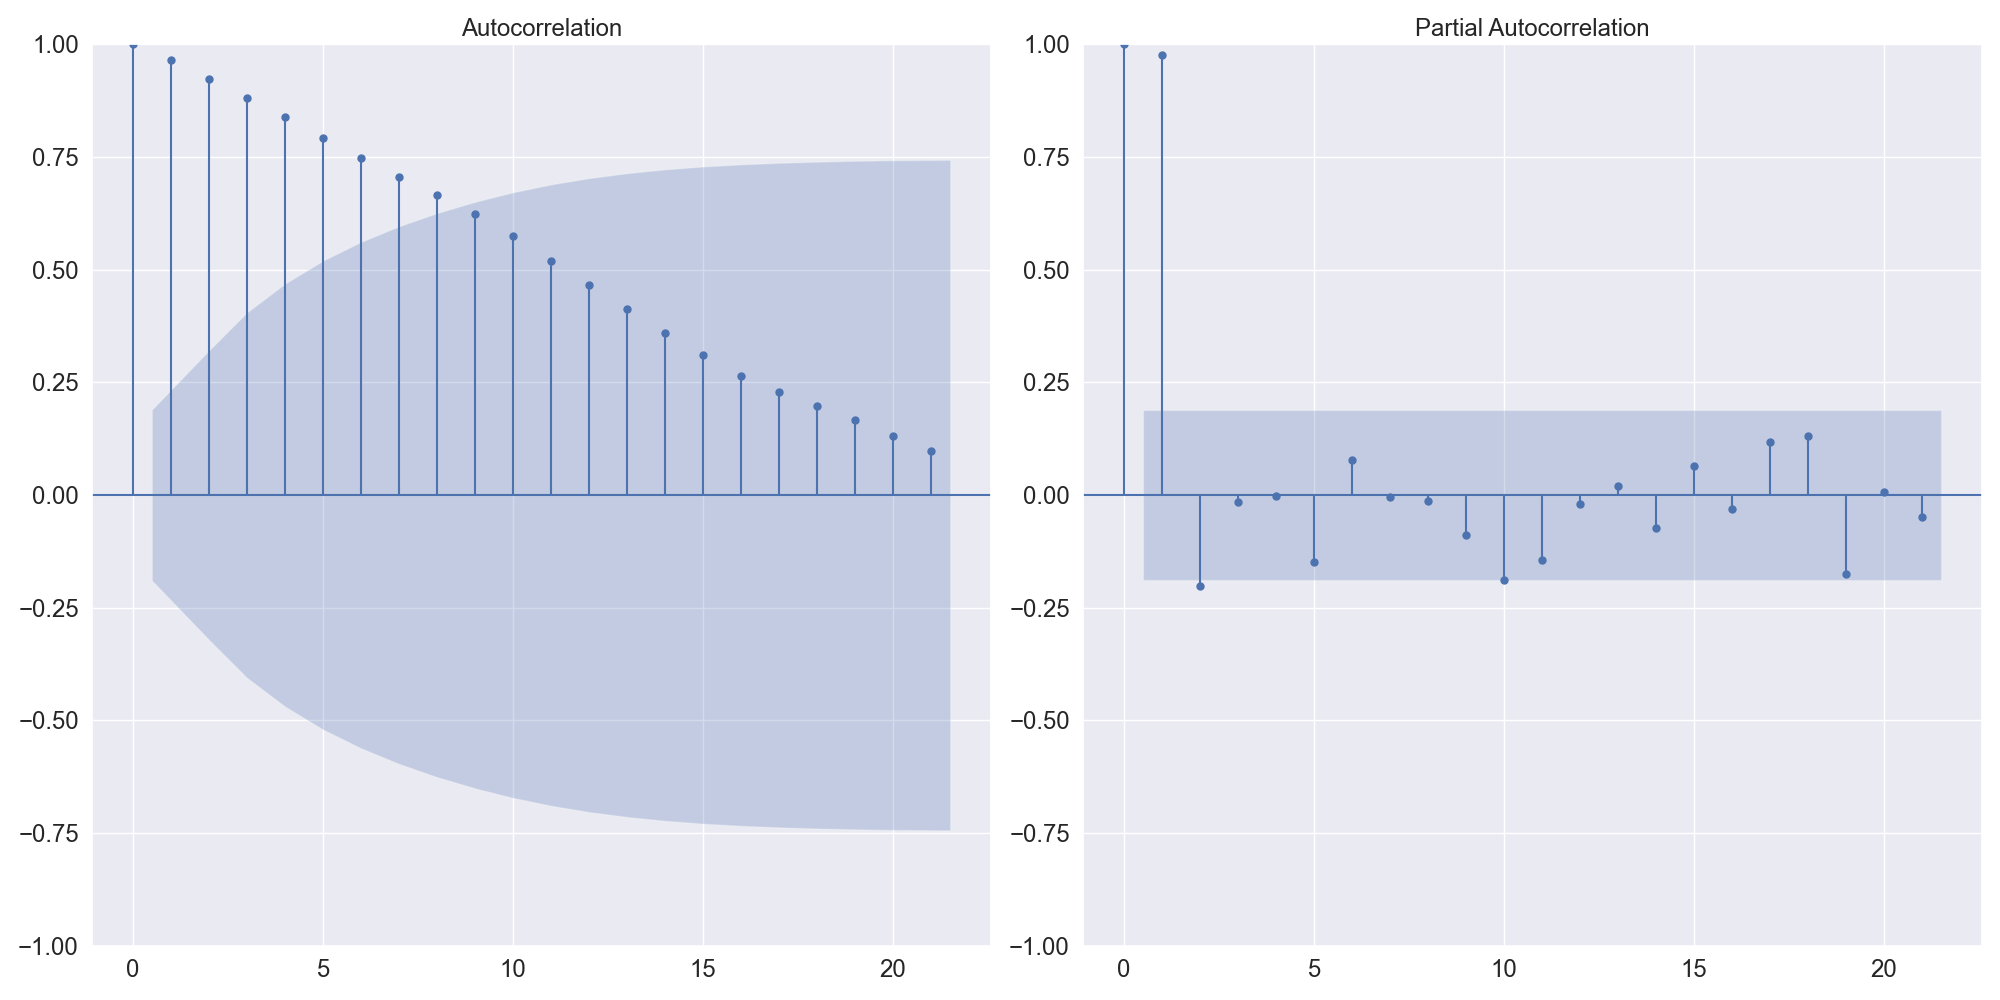
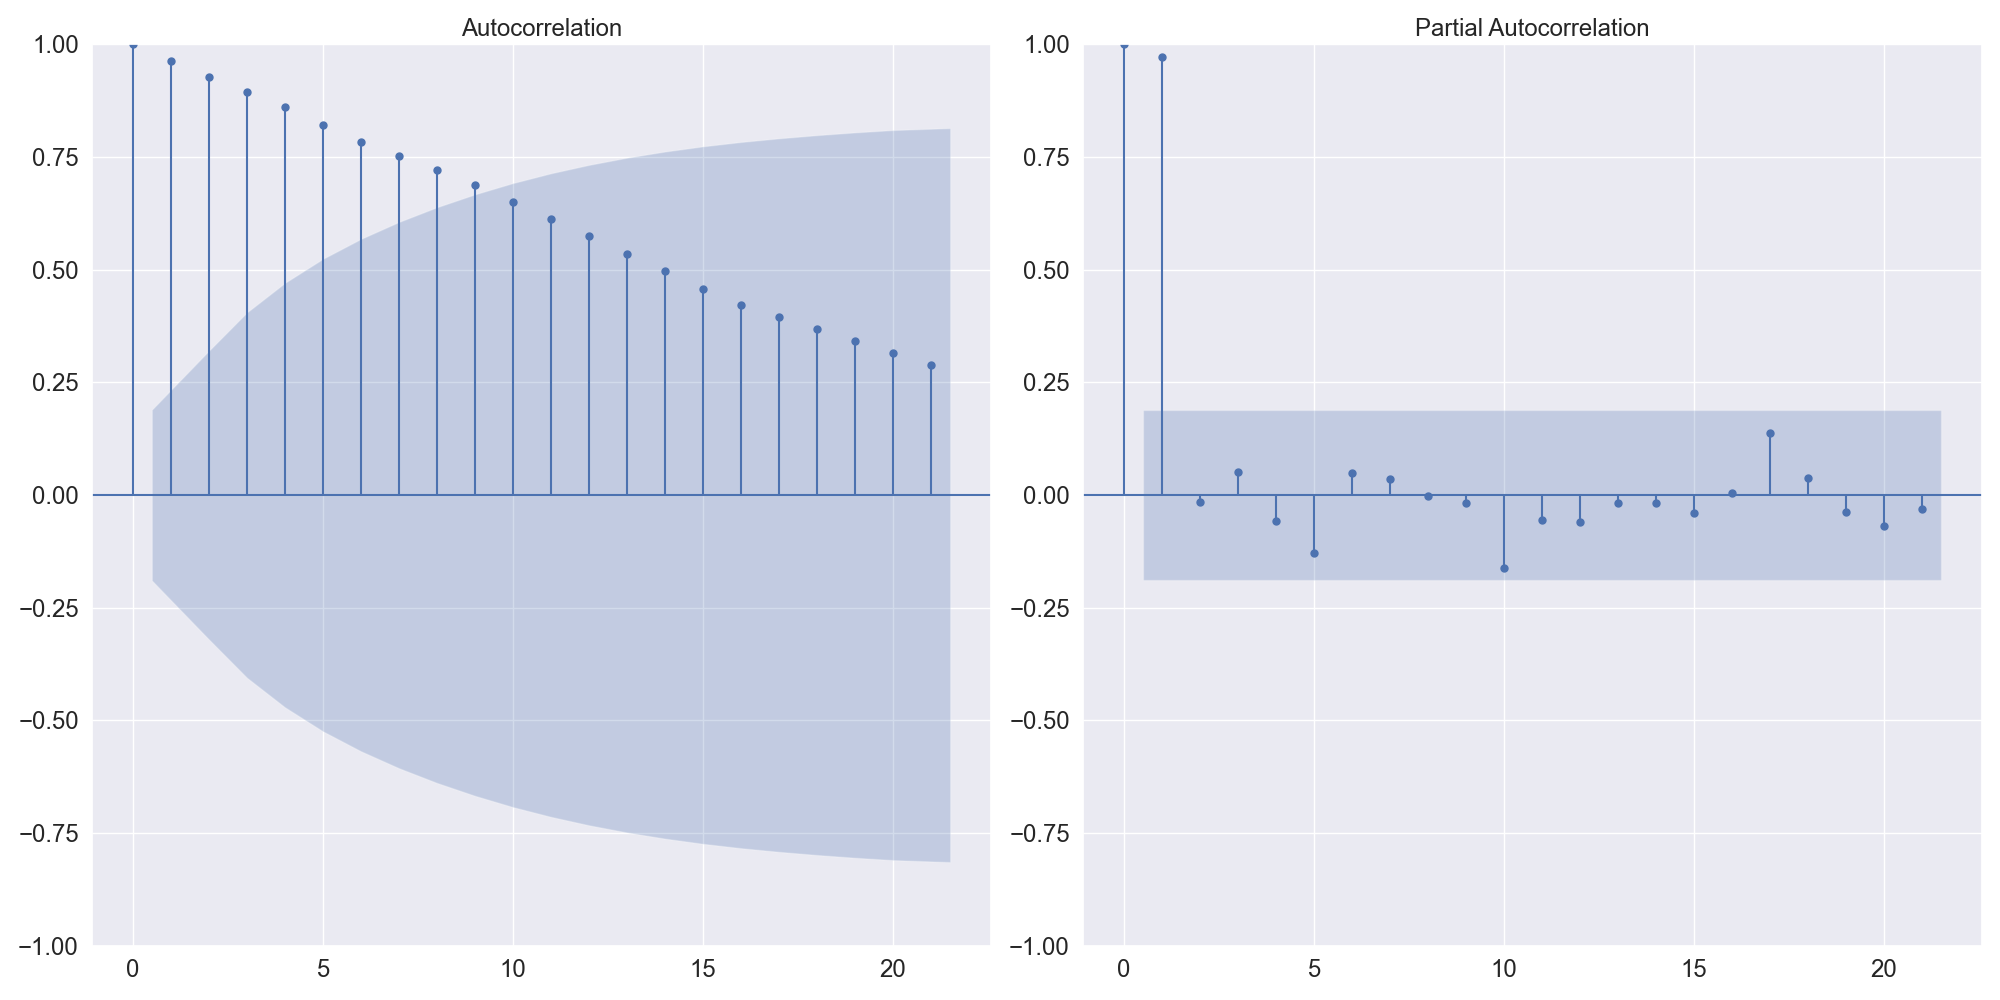
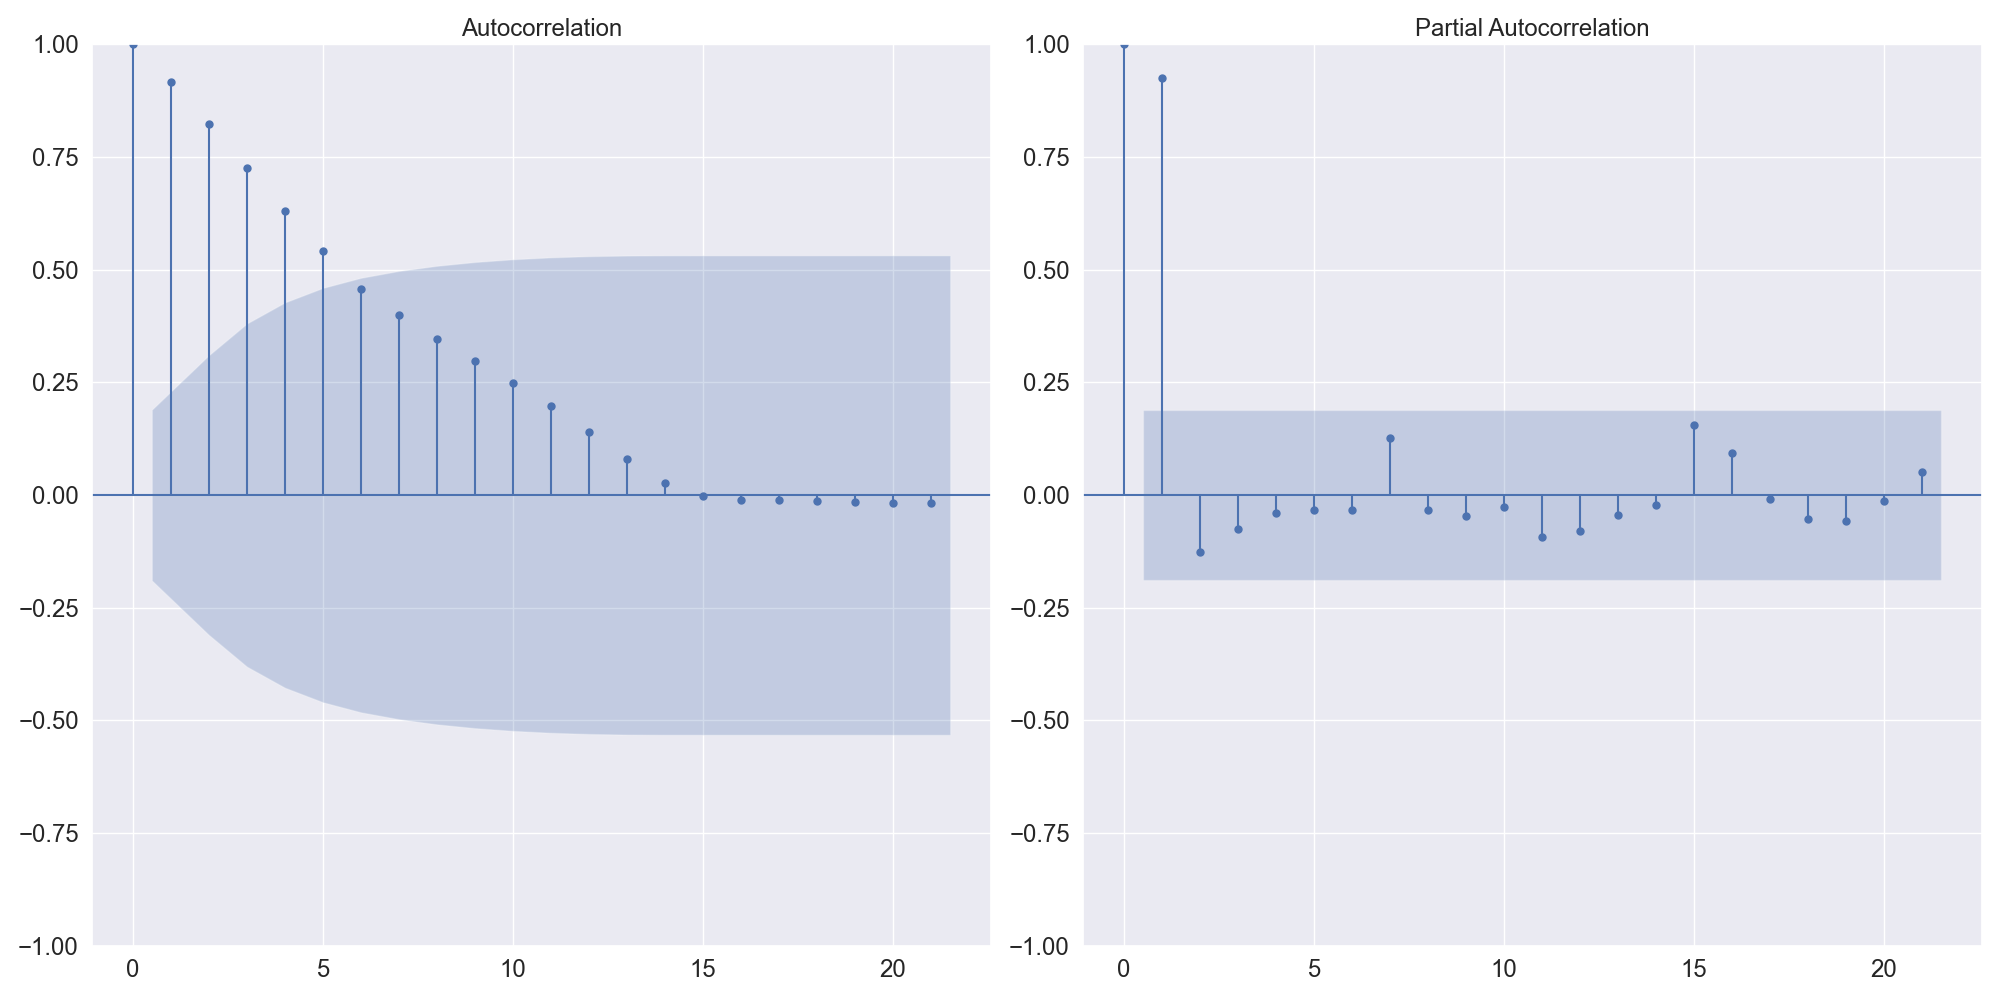

In [10]:
from validmind.model_validation.statsmodels.metrics import SeasonalityDetectionWithACFandPACF
test_context = TestContext(train_ds=vm_train_ds)
acf_metric = SeasonalityDetectionWithACFandPACF(test_context=test_context)
acf_metric.run()
acf_metric.result.show()

**Step 3: Residuals Analysis**

Residuals series, histogram, Q-Q and ACF plots.

In [11]:
# Comment: How do I pass the residuals of seasonal decomponsition done before using SeasonalDecomposeMetricWithFigure?
from validmind.model_validation.statsmodels.metrics import ResidualsVisualInspection
test_context = TestContext(train_ds=vm_train_ds)
rvi_metric = ResidualsVisualInspection(test_context=test_context)
rvi_metric.run()

TestPlanMetricResult(figures=[Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None)], metric=None)


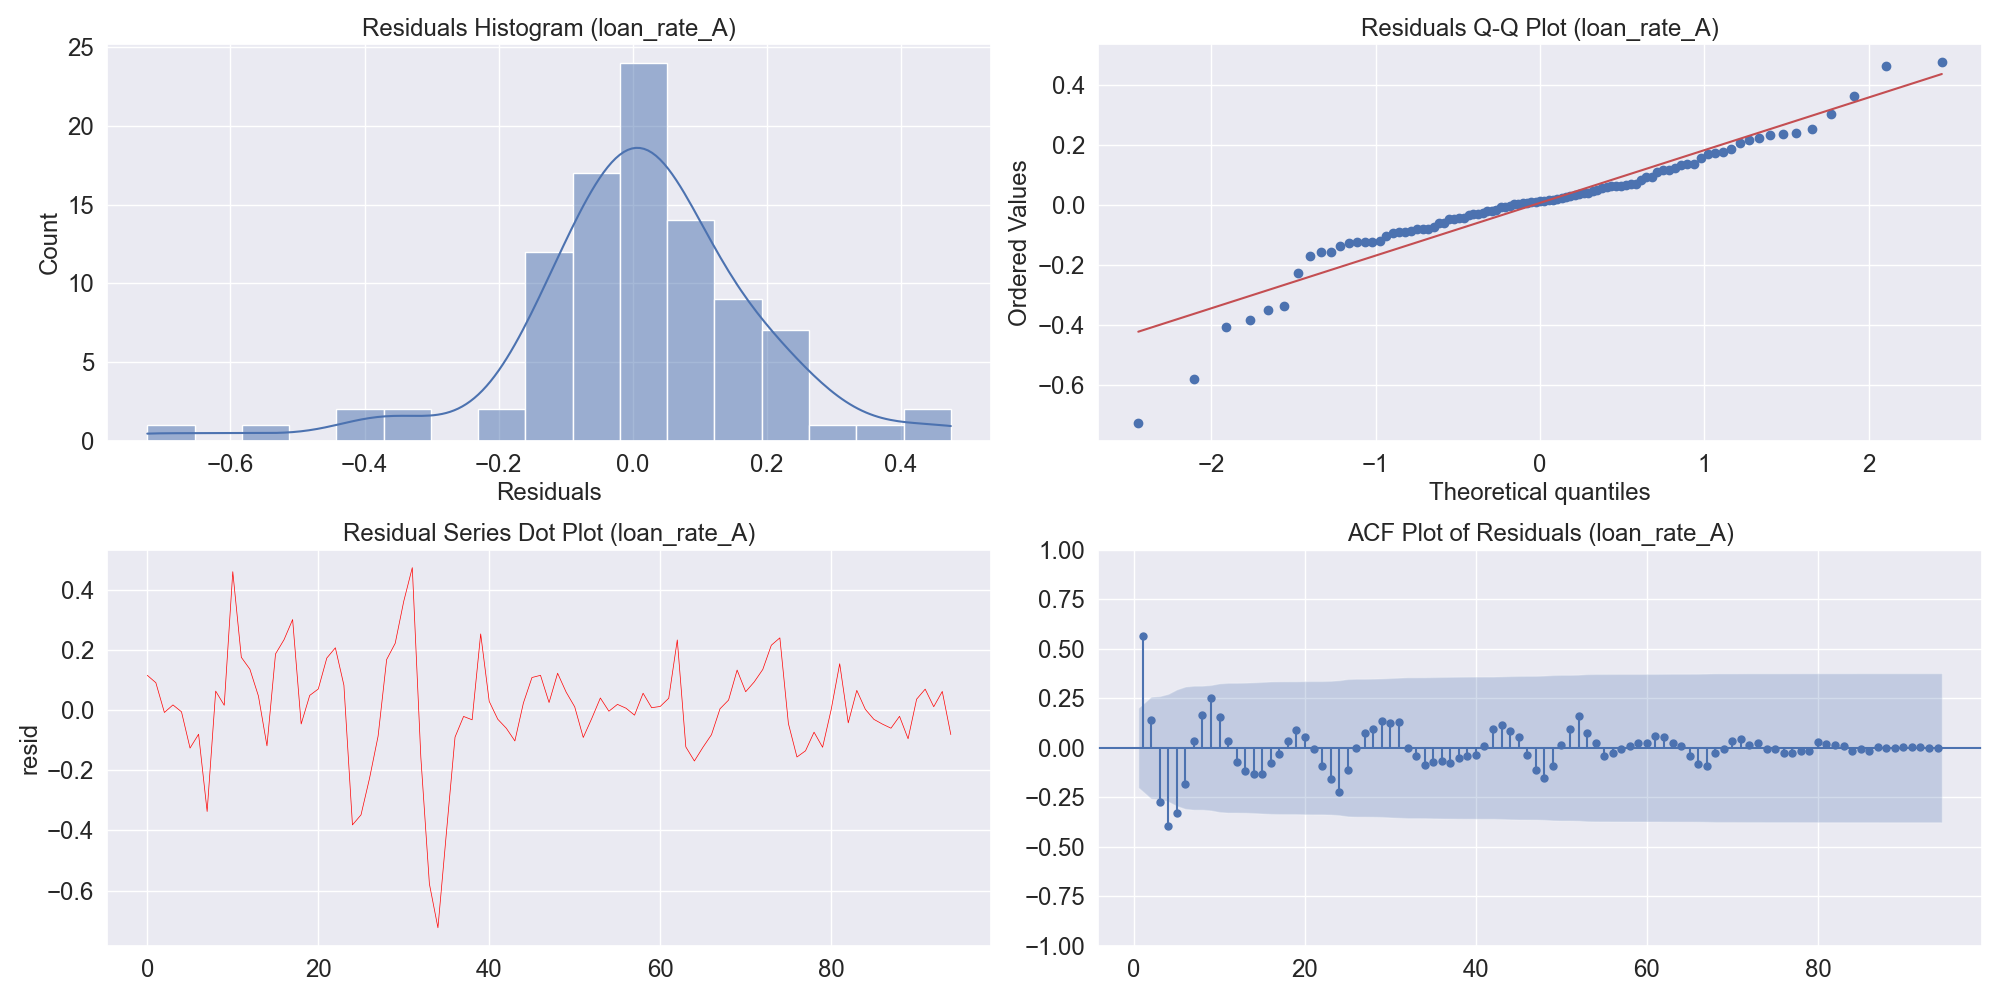
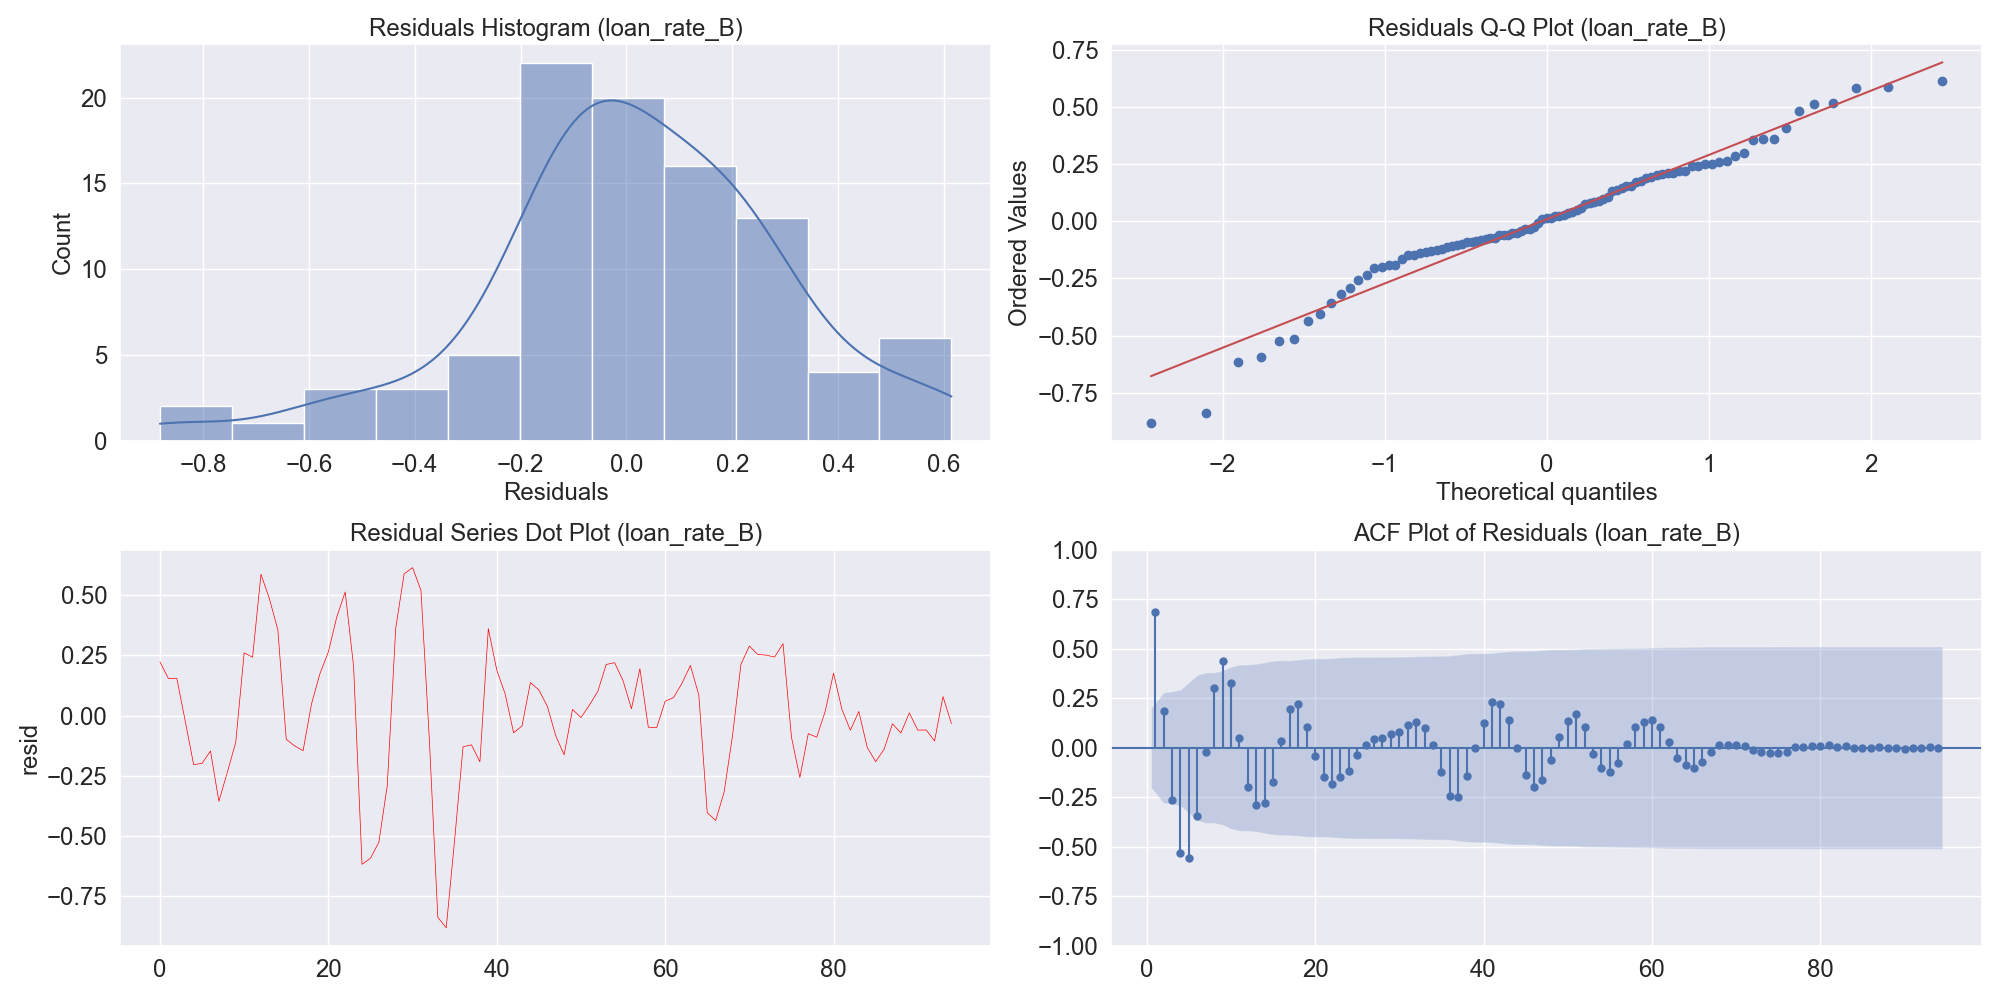
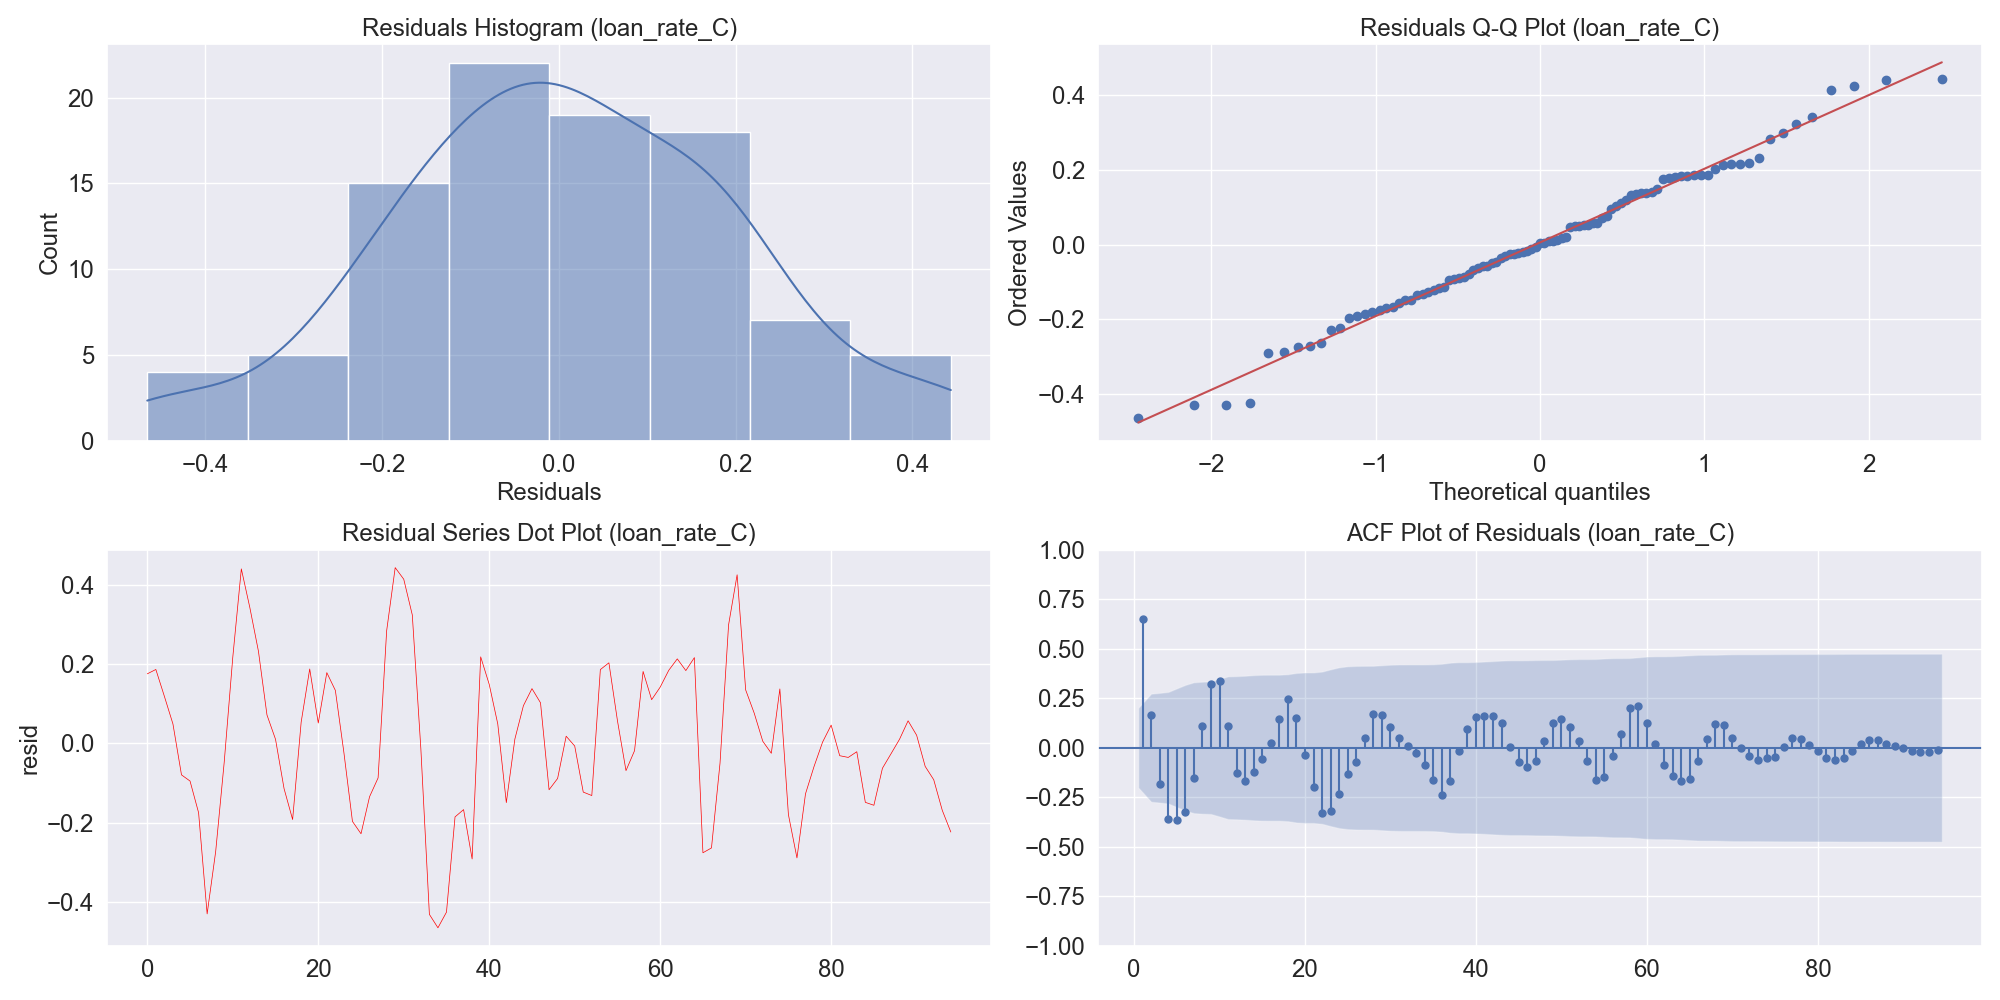
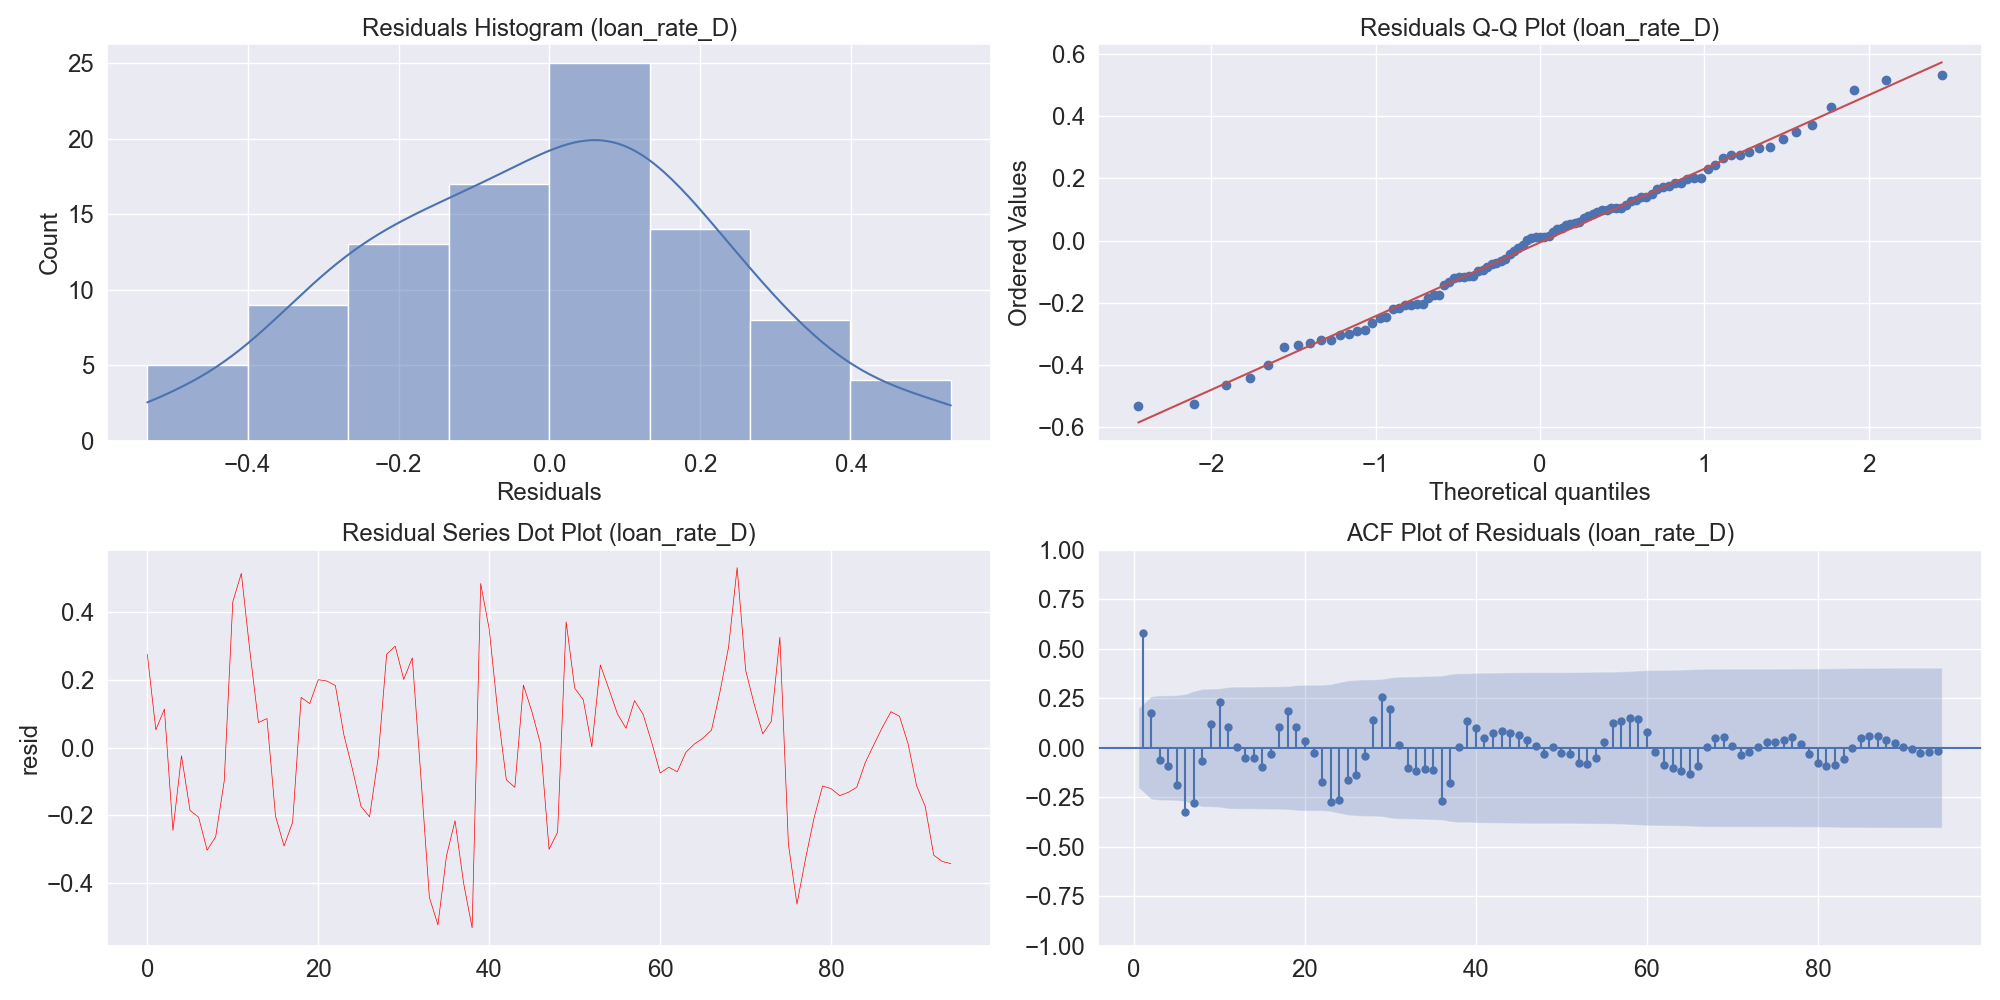
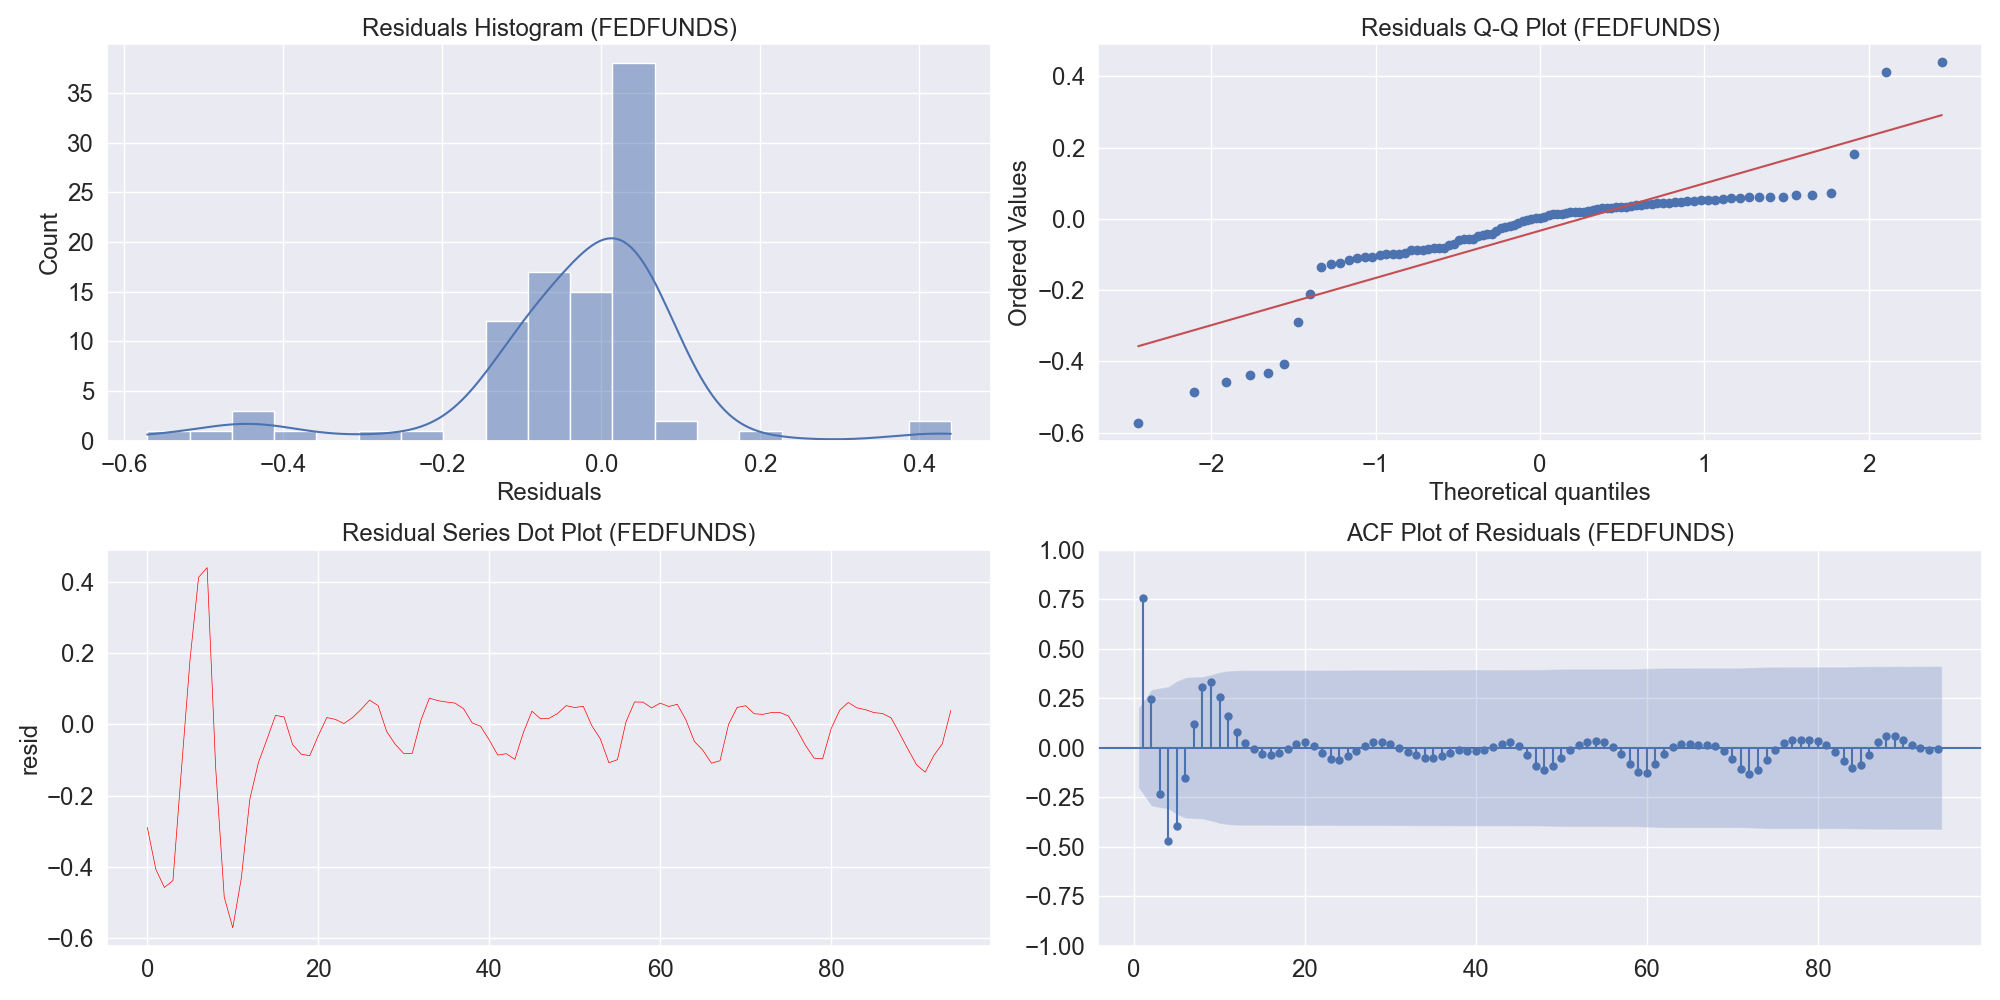

In [12]:
rvi_metric.result.show()

Test if Residuals are Normaly Distributed.

In [13]:
# Comment: How do I pass the residuals of seasonal decomponsition done before using SeasonalDecomposeMetricWithFigure?
vm.run_test_plan("normality_test_plan", train_ds=vm_train_ds, test_ds=vm_test_ds)

Test if Residuals are Autocorrelated.

In [14]:
# Comment: How do I pass the residuals of seasonal decomponsition done before using SeasonalDecomposeMetricWithFigure?
vm.run_test_plan("autocorrelation_test_plan", train_ds=vm_train_ds, test_ds=vm_test_ds)

**Step 4: Test for seasonality using Unit Root test**

In [15]:
vm.run_test_plan("unit_root_test_plan", train_ds=vm_train_ds, test_ds=vm_test_ds)

Running Metric: kpss:  20%|██        | 1/5 [00:00<00:00, 94.37it/s]            The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.



**Step 4.1: Run the Seasonality Test Plan** (should run all the previous tests)

**Step 5: Analyze the seasonality test results**

**Step 6: Interpret the results**

**Step 7: Handle seasonality**

# 4.2. Methodology Selection and Development

## 4.2.4 Variable Analysis

 ## A. Feature Analysis

## A.1. Univariate Analysis

### Visual Inspection

## A.2 Multivariave Analysis

### Visual Inspection

## B. Variable Selection

### ARIMA Analysis

**Step 1: Identify the Integration order (Stationarity Analysis)**

Stationarity Analysis using Unit Root Tests. 

In [16]:
vm.run_test_plan("unit_root_test_plan", train_ds=vm_train_ds, test_ds=vm_test_ds)

Running Metric: kpss:  20%|██        | 1/5 [00:00<00:00, 86.43it/s]            The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.



Automatic identification of Integration order.

In [17]:
from validmind.model_validation.statsmodels.metrics import ADFIntegrationOrderDecision
test_context = TestContext(train_ds=vm_train_ds)
auto_adf_metric = ADFIntegrationOrderDecision(test_context=test_context)
auto_adf_metric.run()

divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log


TestPlanMetricResult(figures=None, metric=MetricResult(type='', scope='', key='', value={'loan_rate_A': [{'order': 0, 'pvalue': nan}, {'order': 1, 'pvalue': 3.995955517892278e-16}], 'loan_rate_B': [{'order': 0, 'pvalue': nan}, {'order': 1, 'pvalue': 4.5038714614971706e-11}], 'loan_rate_C': [{'order': 0, 'pvalue': nan}, {'order': 1, 'pvalue': 3.831147653625685e-11}], 'loan_rate_D': [{'order': 0, 'pvalue': nan}, {'order': 1, 'pvalue': 0.06268231532164706}, {'order': 2, 'pvalue': 0.23111298382818662}, {'order': 3, 'pvalue': 0.3857026825339831}], 'FEDFUNDS': [{'order': 0, 'pvalue': nan}, {'order': 1, 'pvalue': 0.07283980043261669}, {'order': 2, 'pvalue': 0.011888636217144016}]}, value_formatter=None))

In [18]:
def display_as_table(adf_results, p_value_threshold=0.05):
    data = []
    for variable, orders in adf_results.items():
        for order_info in orders:
            order = order_info['order']
            p_value = order_info['pvalue']
            decision = "Stationary" if p_value <= p_value_threshold else "Not Stationary"
            data.append([variable, order, p_value, p_value_threshold, decision])

    columns = ['Variable', 'Order', 'P-Value', 'Threshold', 'Decision']
    df = pd.DataFrame(data, columns=columns).set_index('Variable')
    
    return df

table = display_as_table(auto_adf_metric.result.metric.value)
display(table)

,Order,P-Value,Threshold,Decision
Variable,,,,
loan_rate_A,0,NaN,0.05,Not Stationary
loan_rate_A,1,3.995956e-16,0.05,Stationary
loan_rate_B,0,NaN,0.05,Not Stationary
loan_rate_B,1,4.503871e-11,0.05,Stationary
loan_rate_C,0,NaN,0.05,Not Stationary
loan_rate_C,1,3.831148e-11,0.05,Stationary
loan_rate_D,0,NaN,0.05,Not Stationary
loan_rate_D,1,6.268232e-02,0.05,Not Stationary
loan_rate_D,2,2.311130e-01,0.05,Not Stationary


**Step 2: Identify the AR order**

ACF and PACF Plots.

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



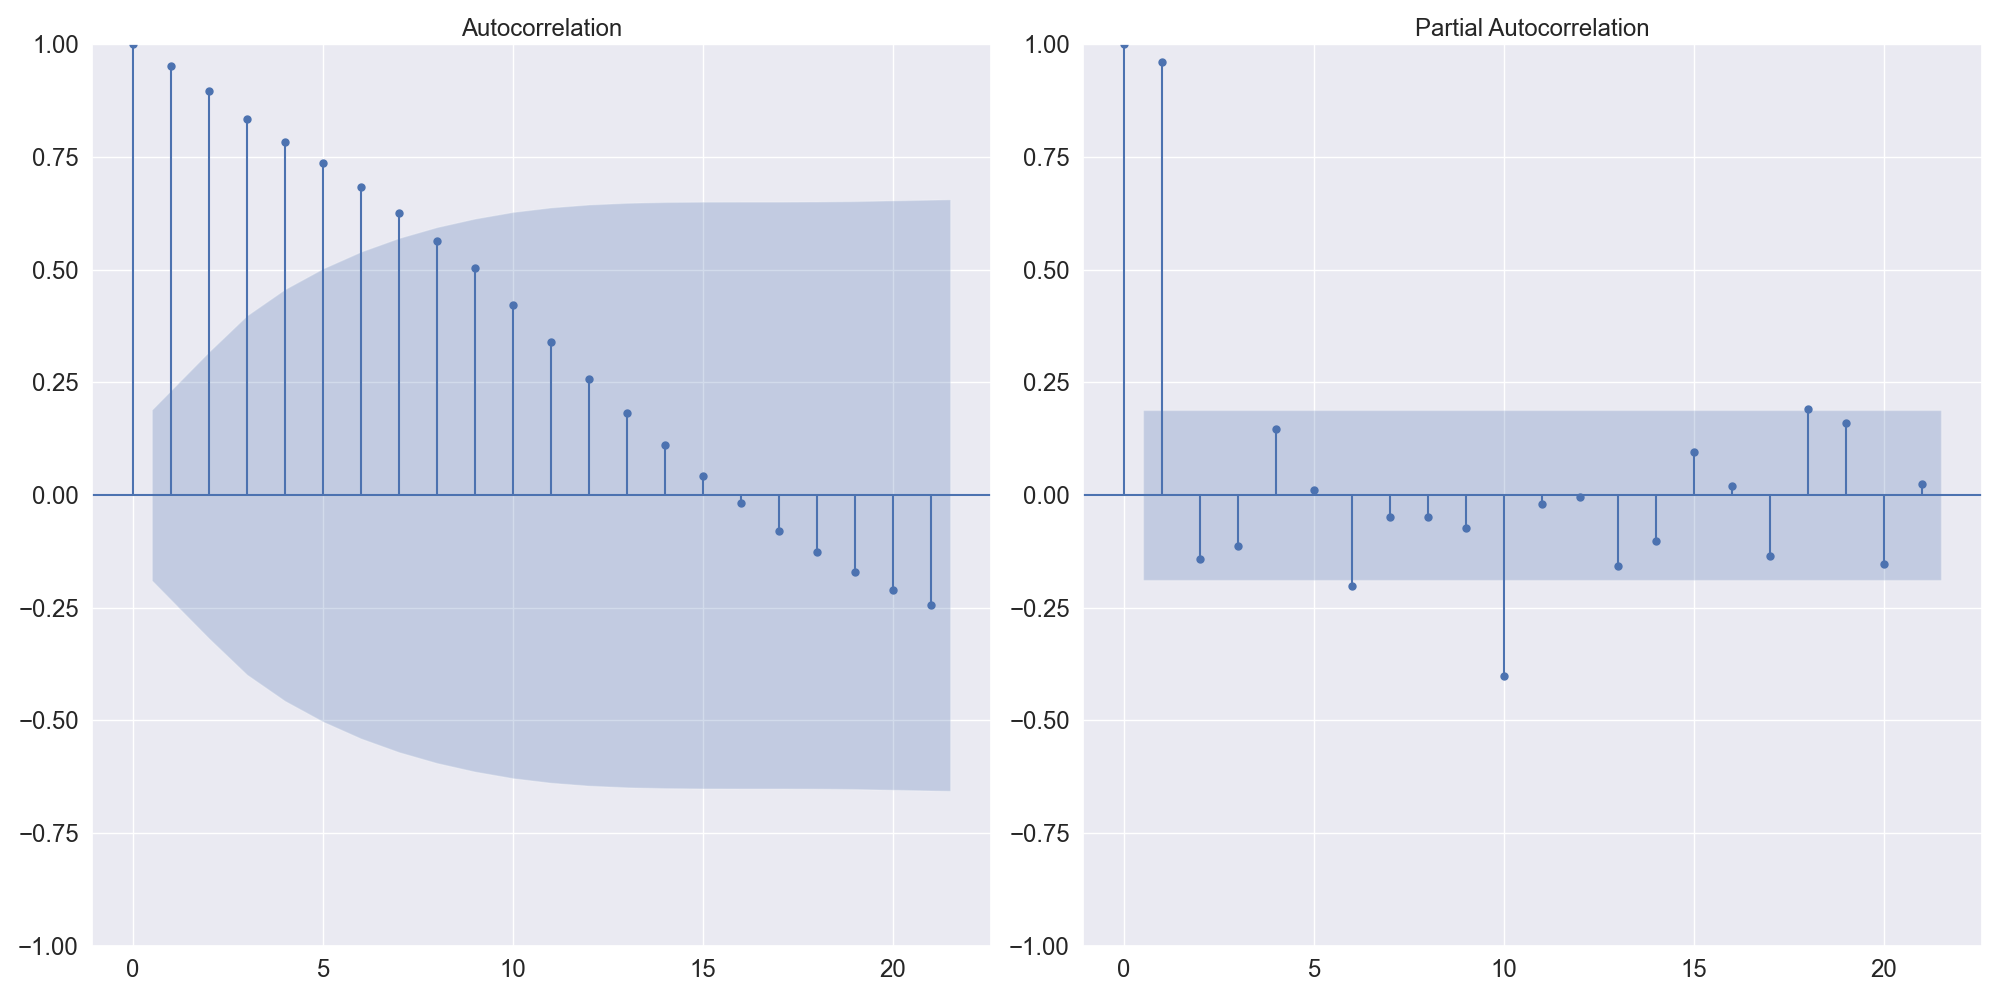
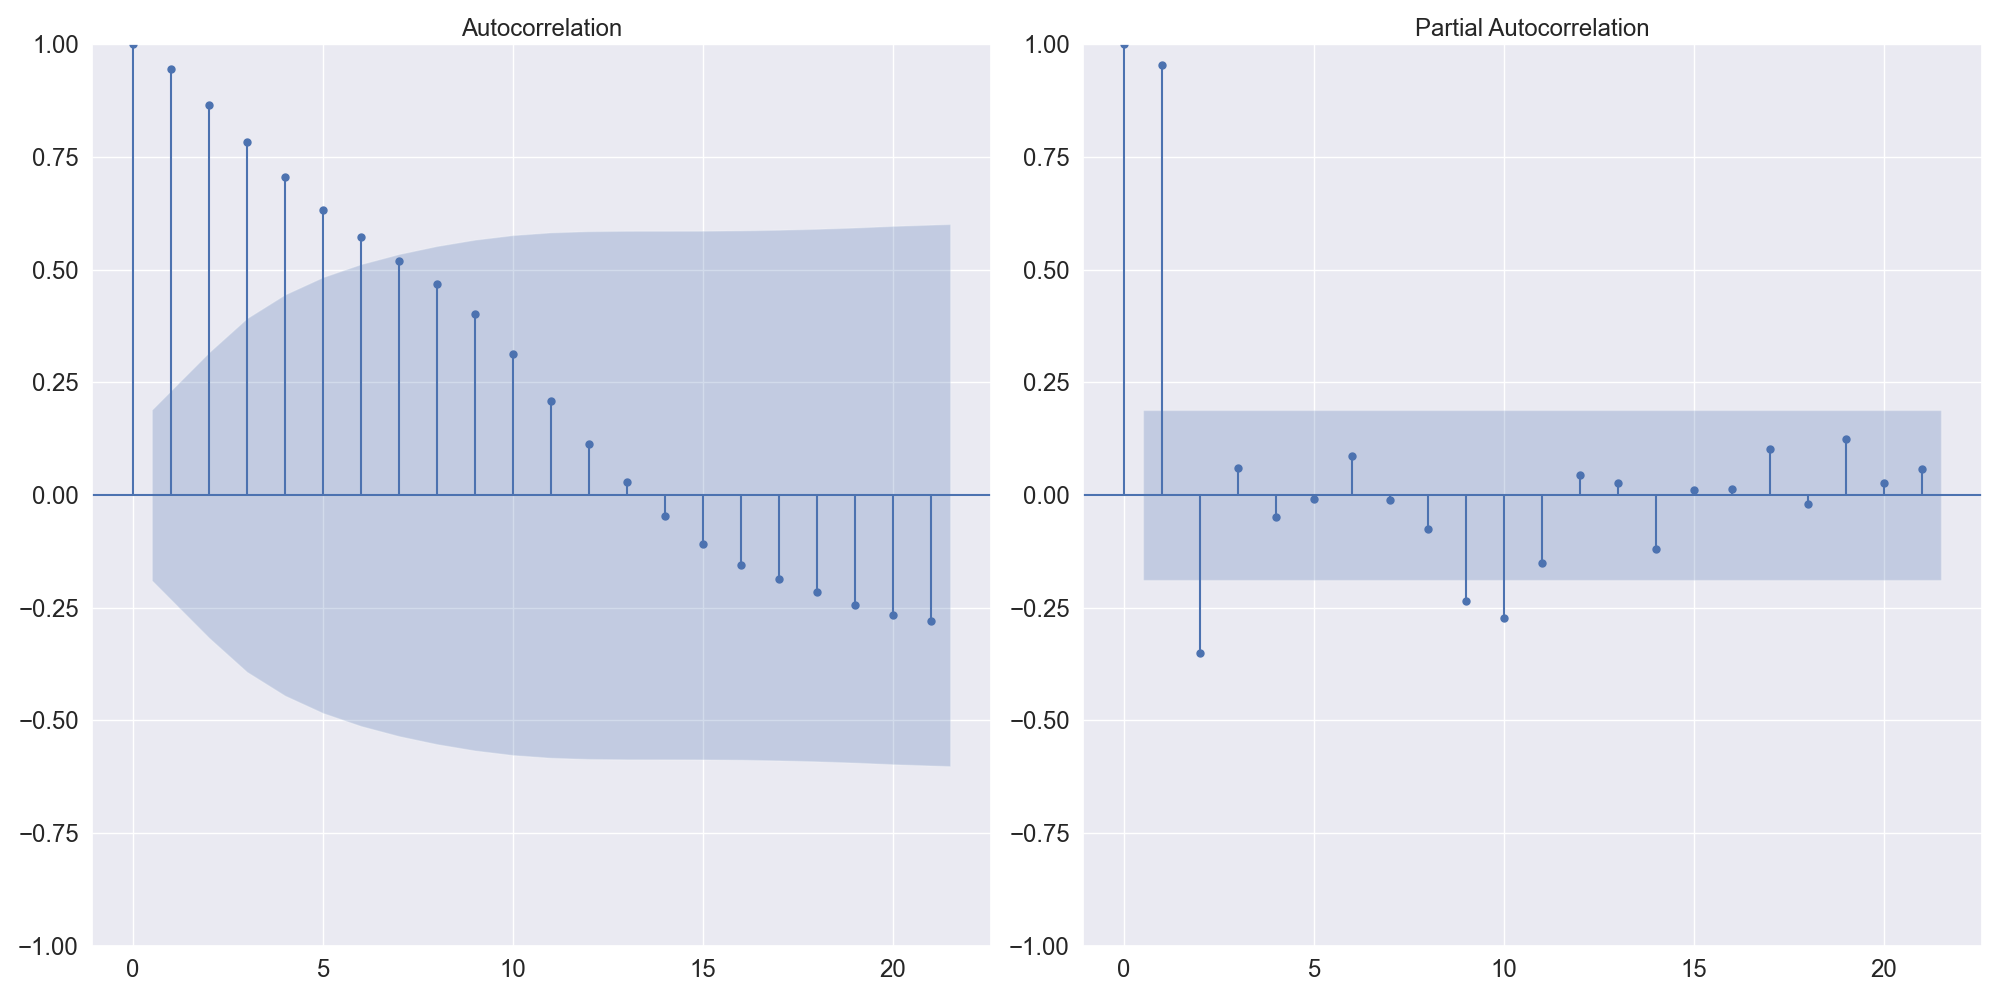
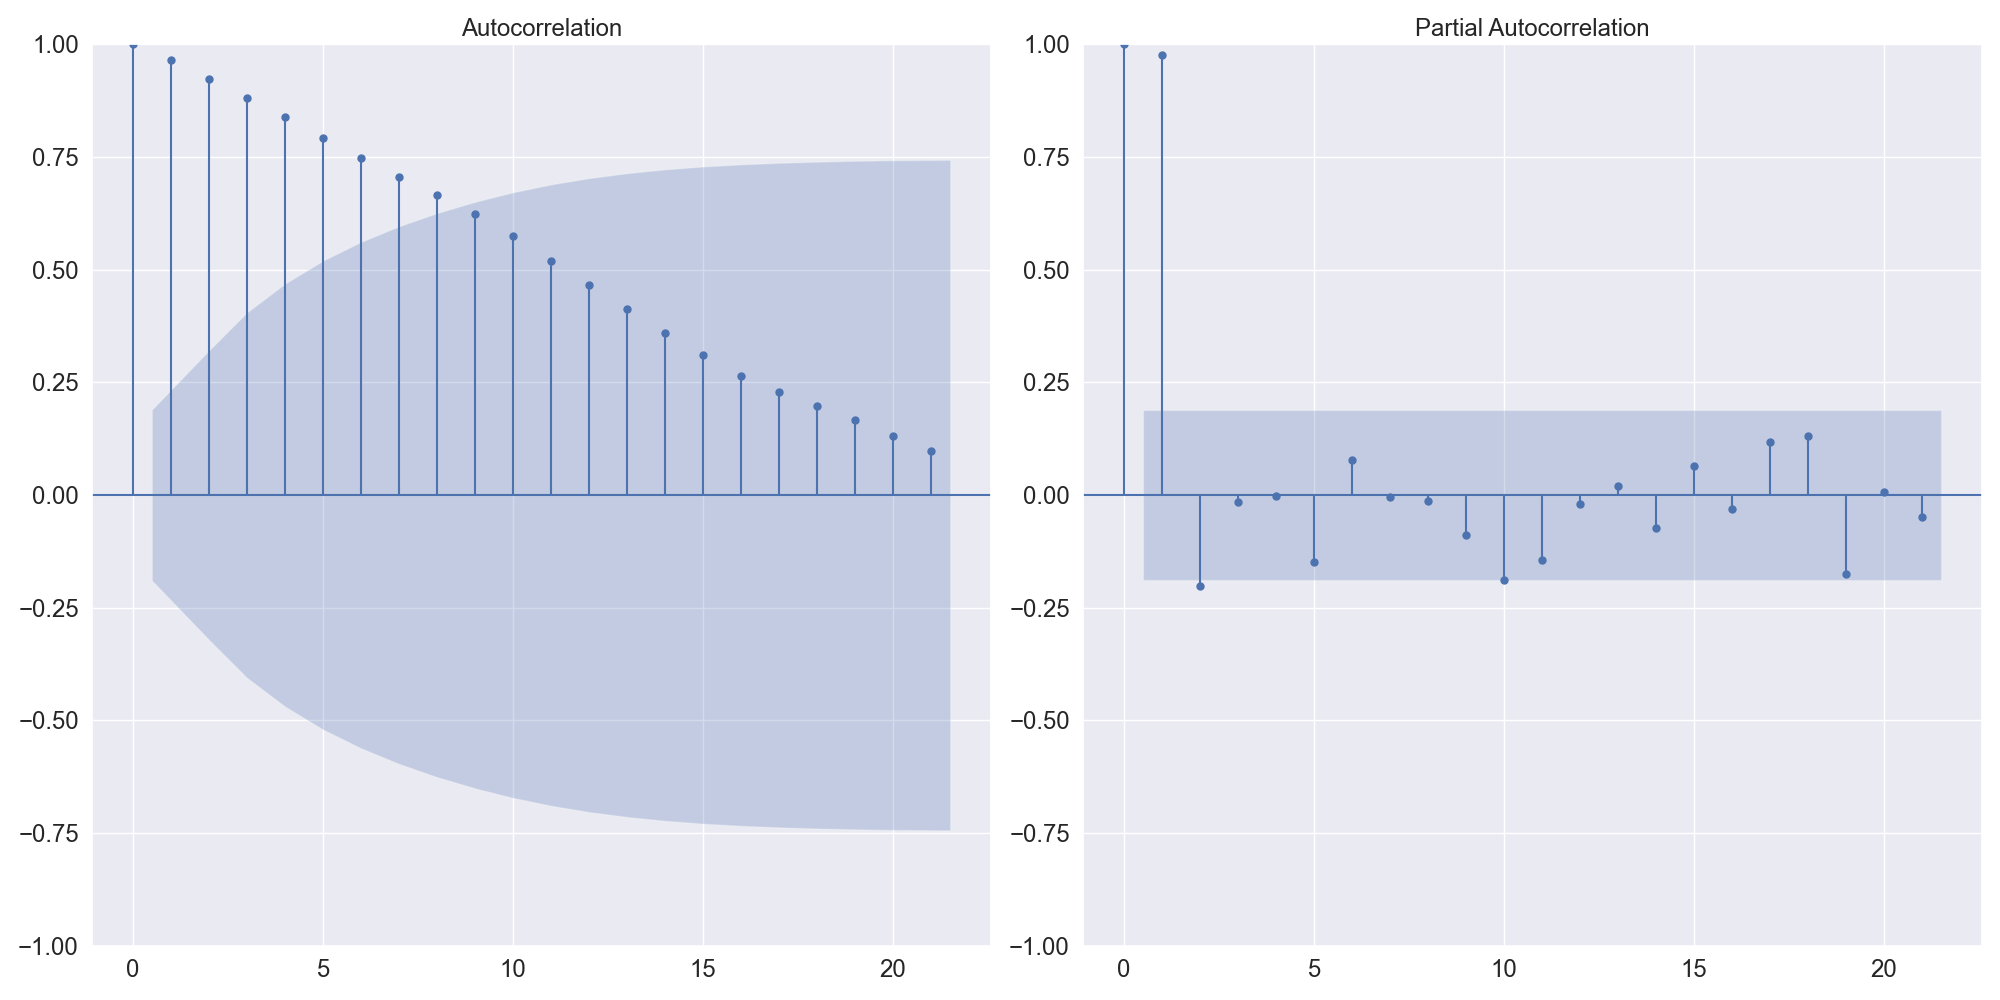
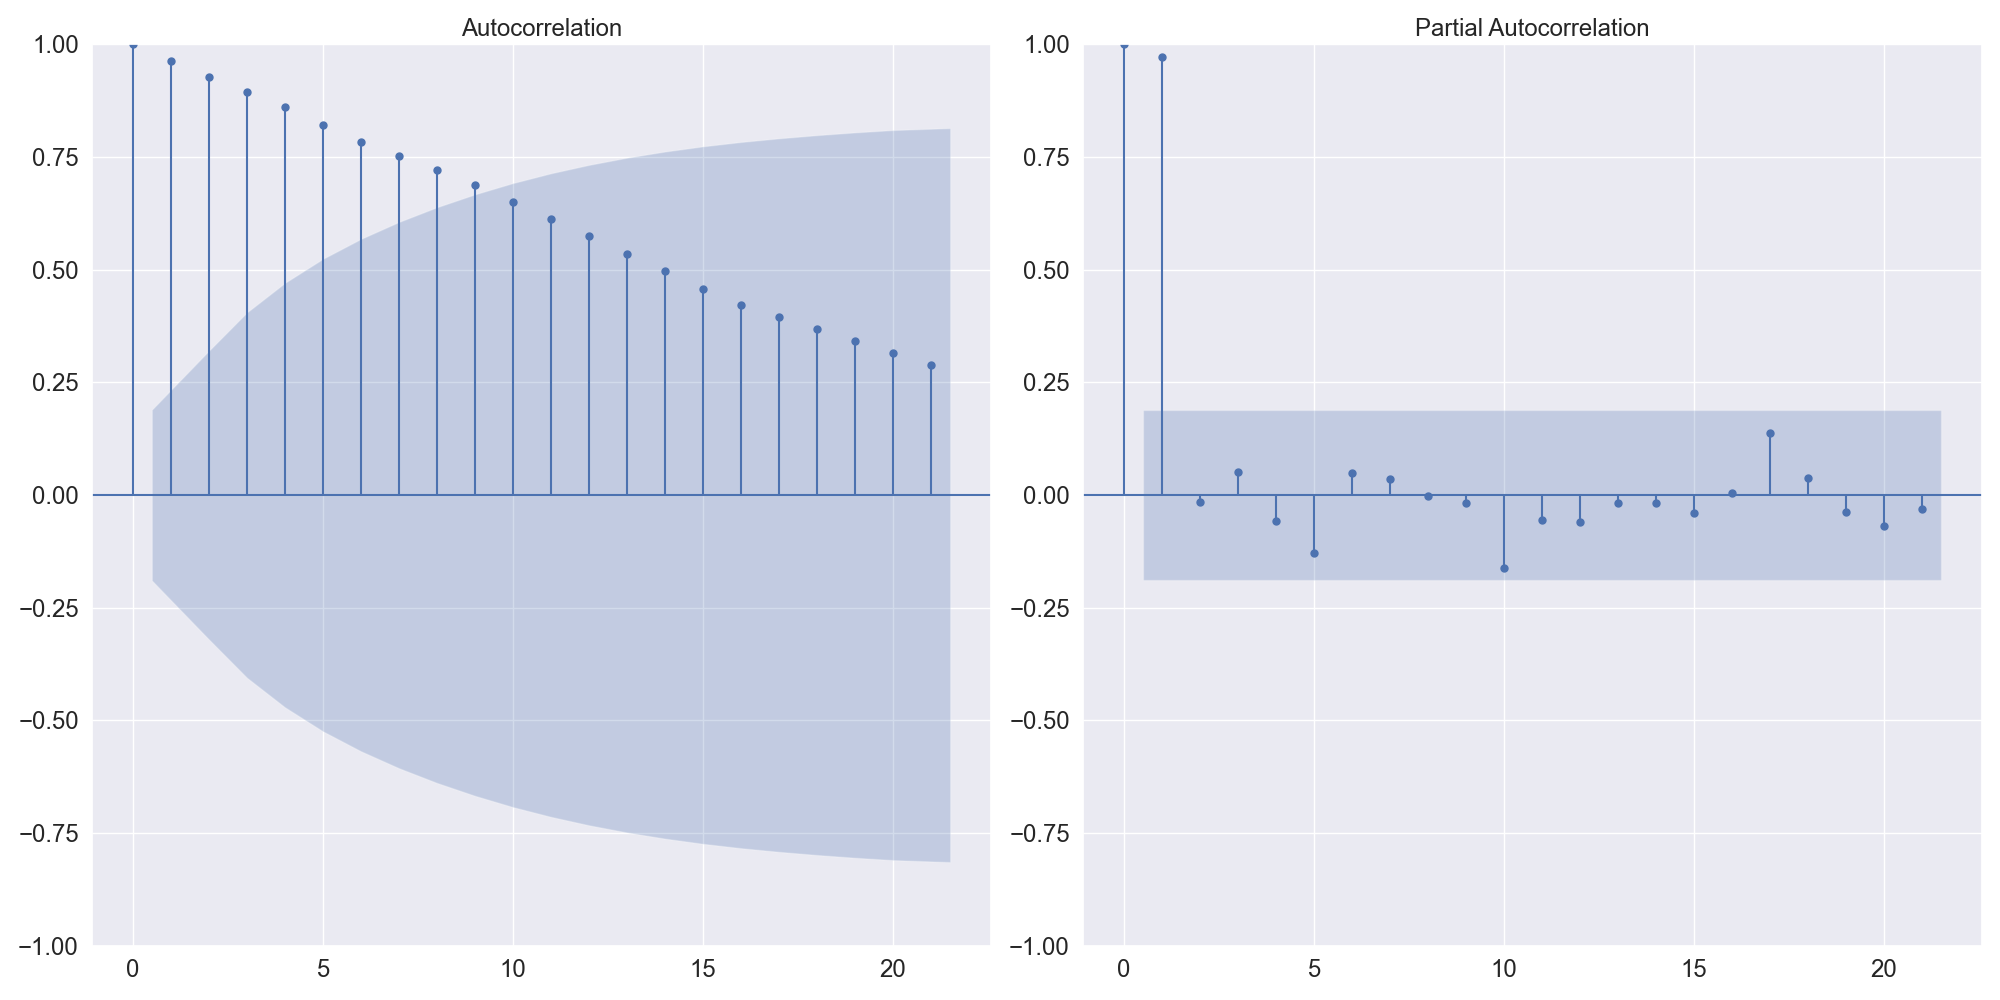
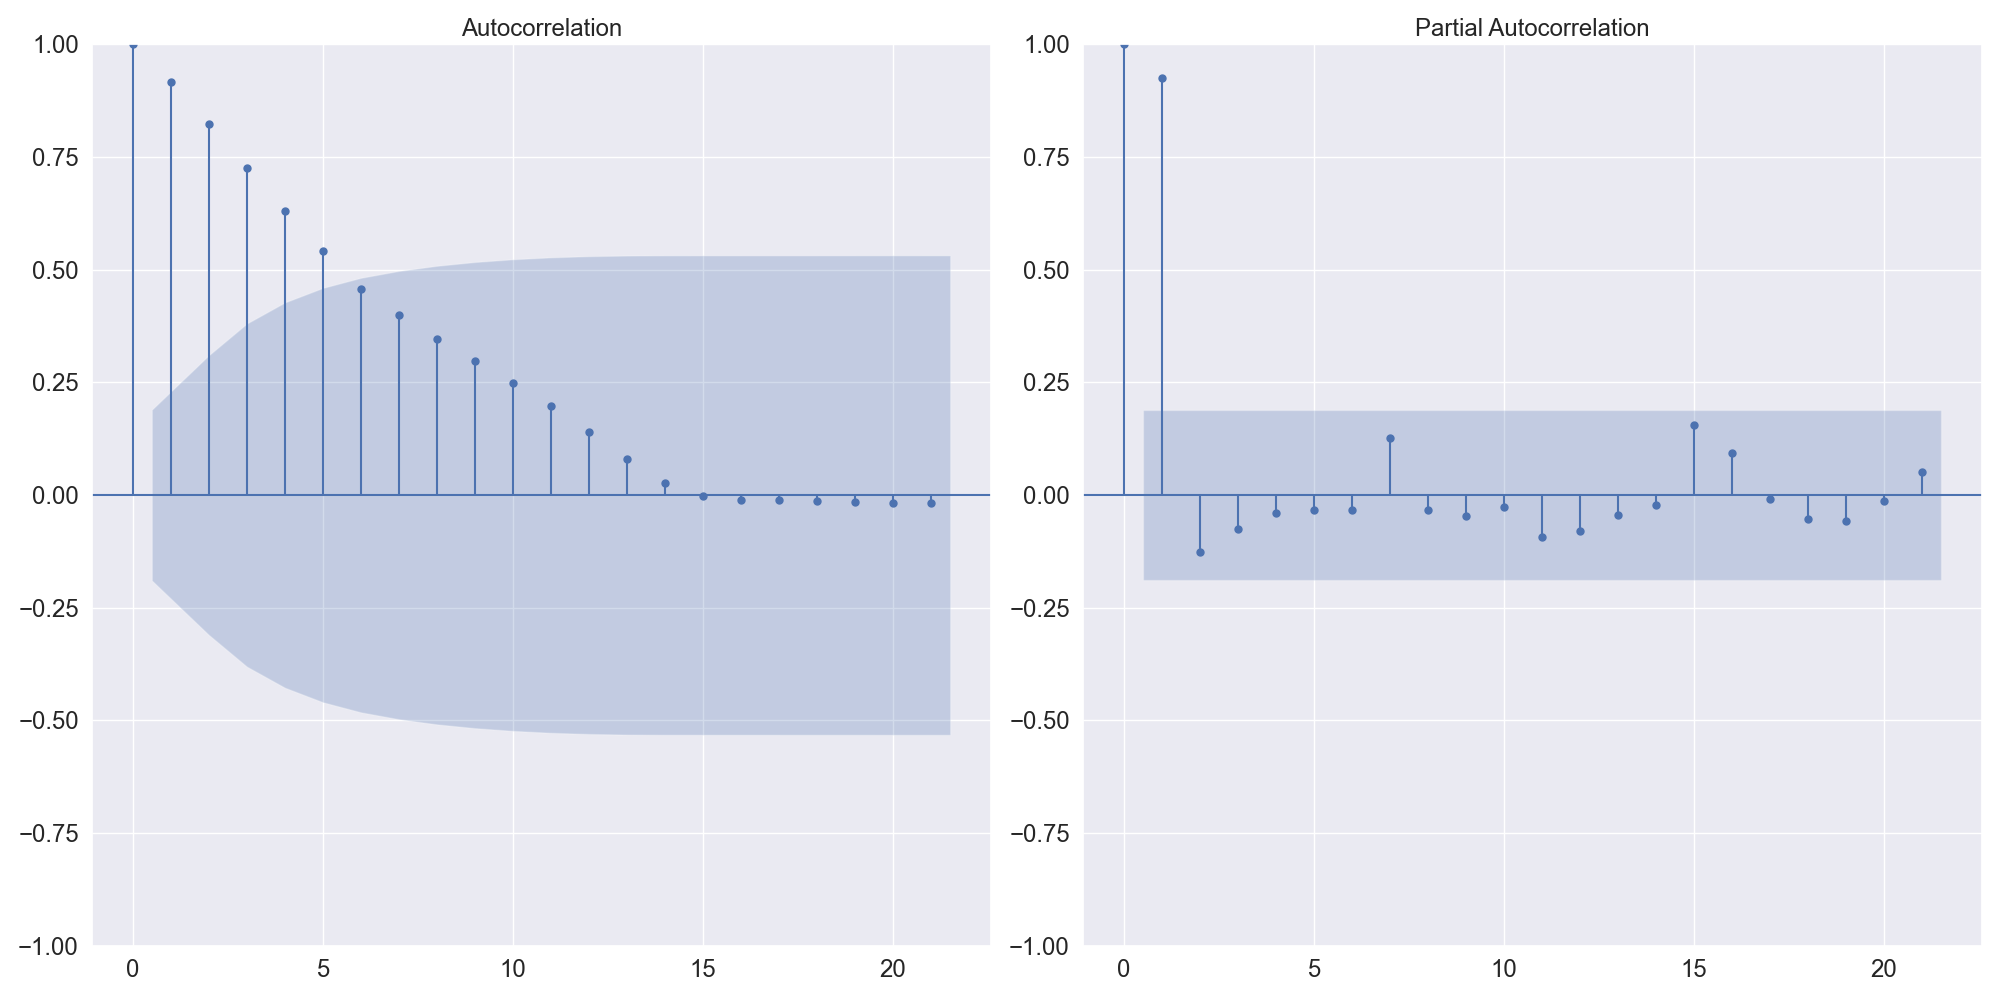

In [19]:
from validmind.model_validation.statsmodels.metrics import ACFandPACFFigures
test_context = TestContext(train_ds=vm_train_ds)
acf_pacf_metric = ACFandPACFFigures(test_context=test_context)
acf_pacf_metric.run()
acf_pacf_metric.result.show()


Automatic AR Order Identification using BIC and AIC.

In [20]:
from validmind.model_validation.statsmodels.metrics import AutoAR
test_context = TestContext(train_ds=vm_train_ds)
acf_pacf_metric = AutoAR(test_context=test_context)
acf_pacf_metric.run()

No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS 

TestPlanMetricResult(figures=None, metric=MetricResult(type='evaluation', scope='test', key='auto_ar', value=[{'Variable': 'loan_rate_A', 'AR orders': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'BIC': [-42.66809225191267, -37.55903912413851, -31.643200906971778, -26.7017596575161, -20.74664873814713, -18.68882880997353, -13.559595318926696, -8.050223623105367, -2.3427774877565497, -6.514151274196834], 'AIC': [-50.65840953424887, -48.174880524768604, -44.86515540267864, -42.510133586893915, -39.12145843113702, -39.60979294470361, -37.006126992819524, -34.00142212445127, -30.777419753132847, -37.41068301623743]}, {'Variable': 'loan_rate_B', 'AR orders': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'BIC': [1.0698216398035534, -6.553199299144232, -1.0328844107399249, 4.465378622560362, 9.359231205725884, 13.996538855189439, 19.15843264559962, 24.137482880081457, 22.01023390576177, 20.664102307883574], 'AIC': [-6.9204956425326465, -17.169040699774325, -14.254838906446786, -11.342995306817453, -9.015578487264008,

**Step 3: Identify the MA order**

ACF and PACF Plots.

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



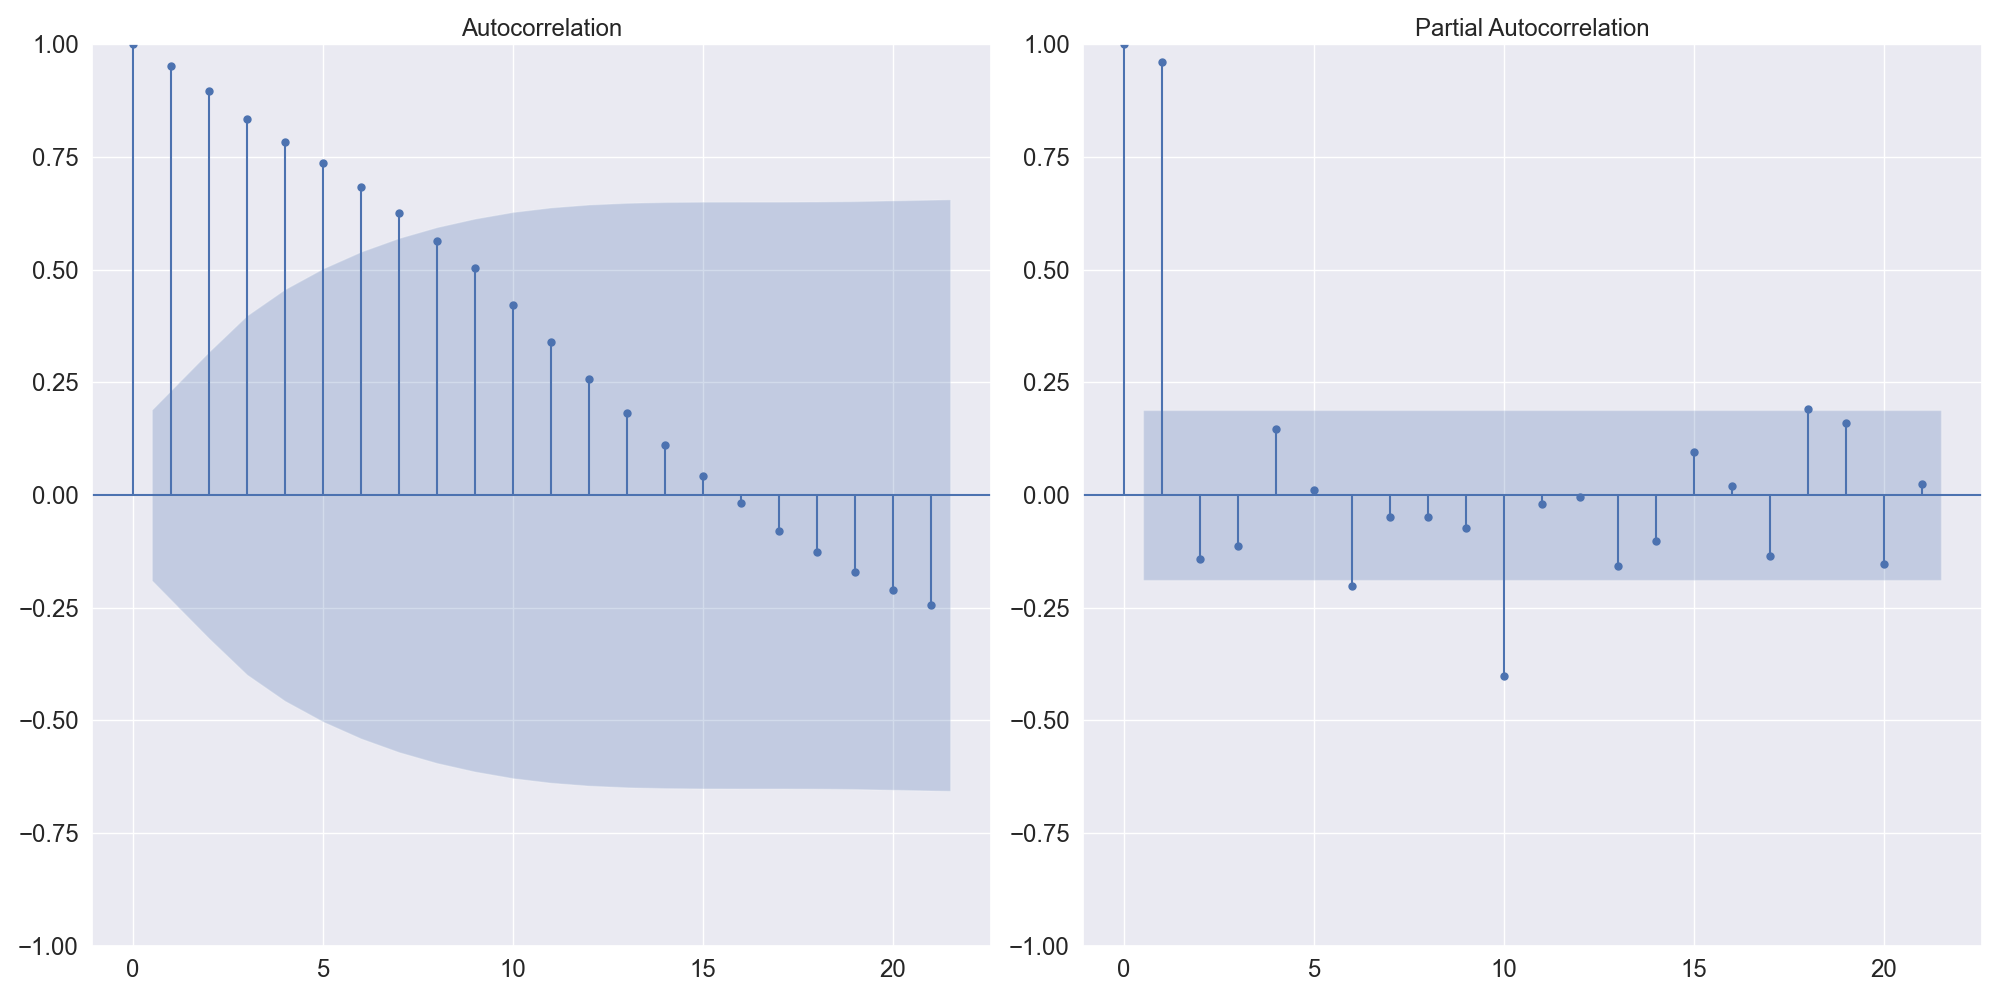
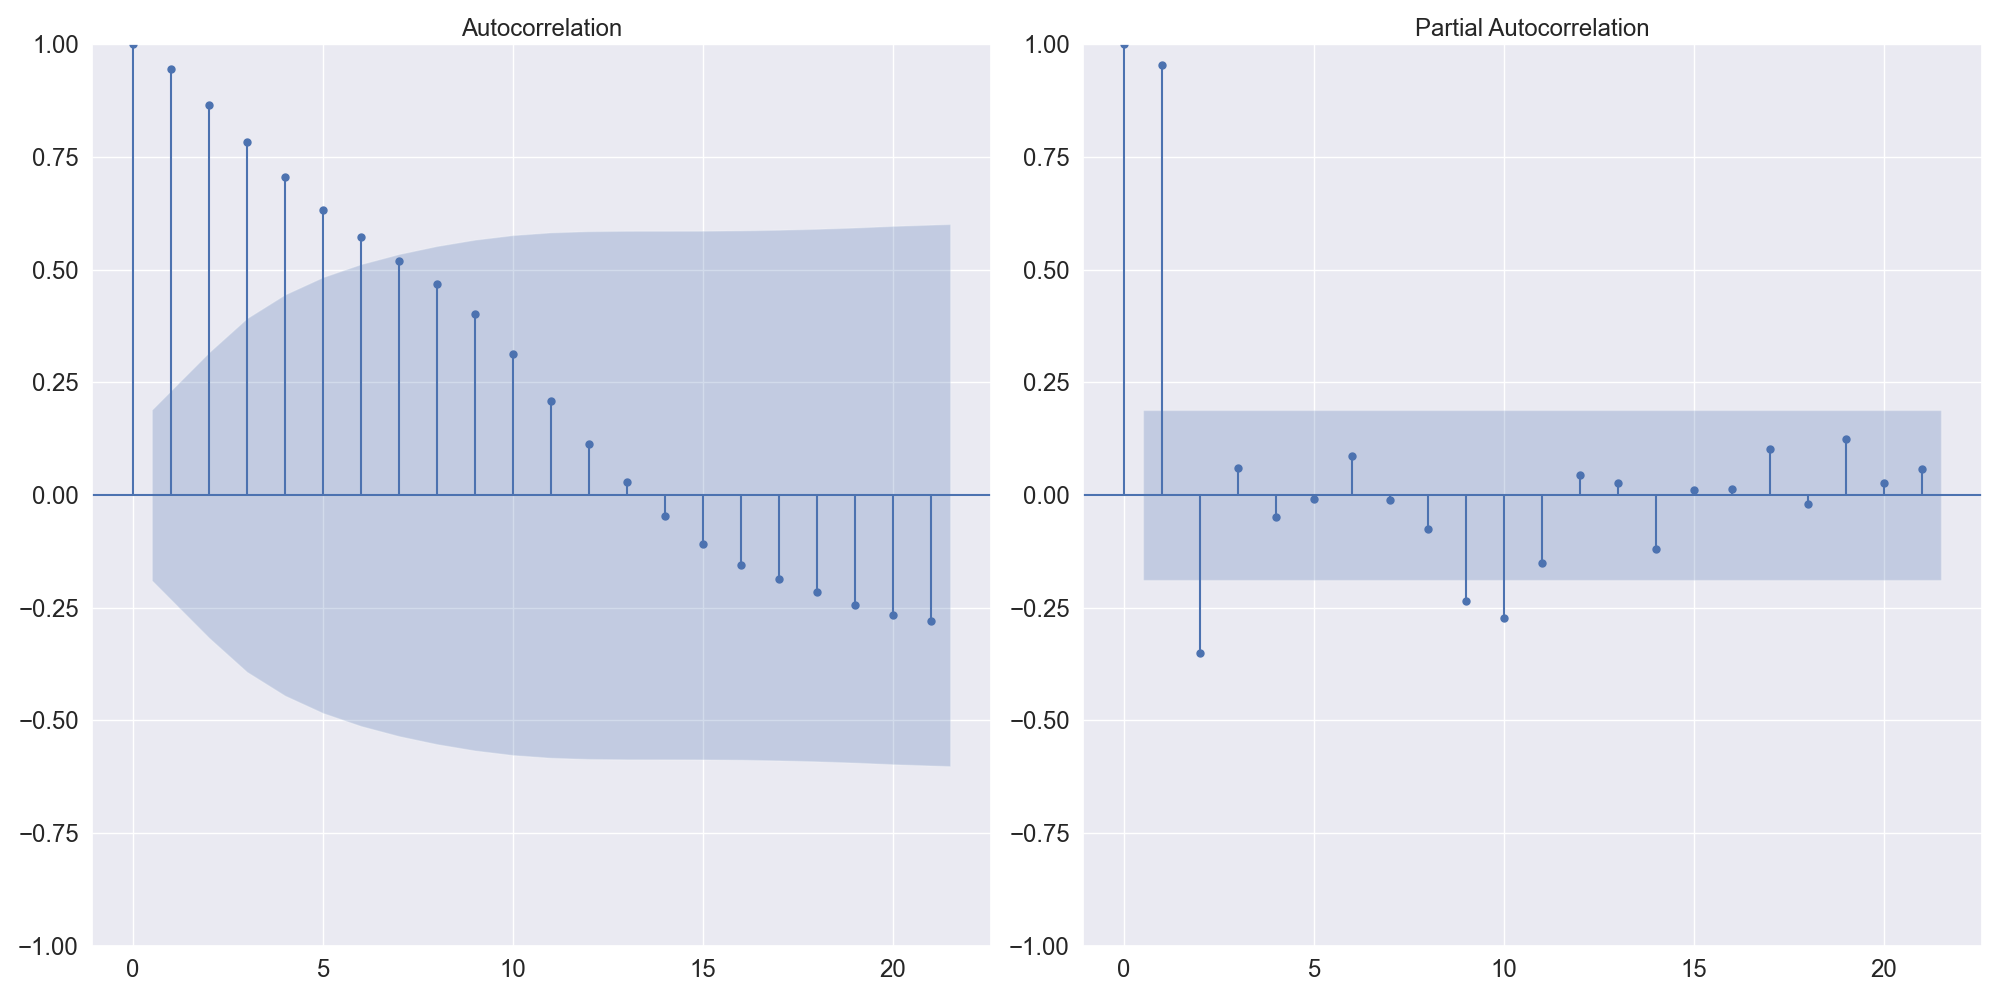
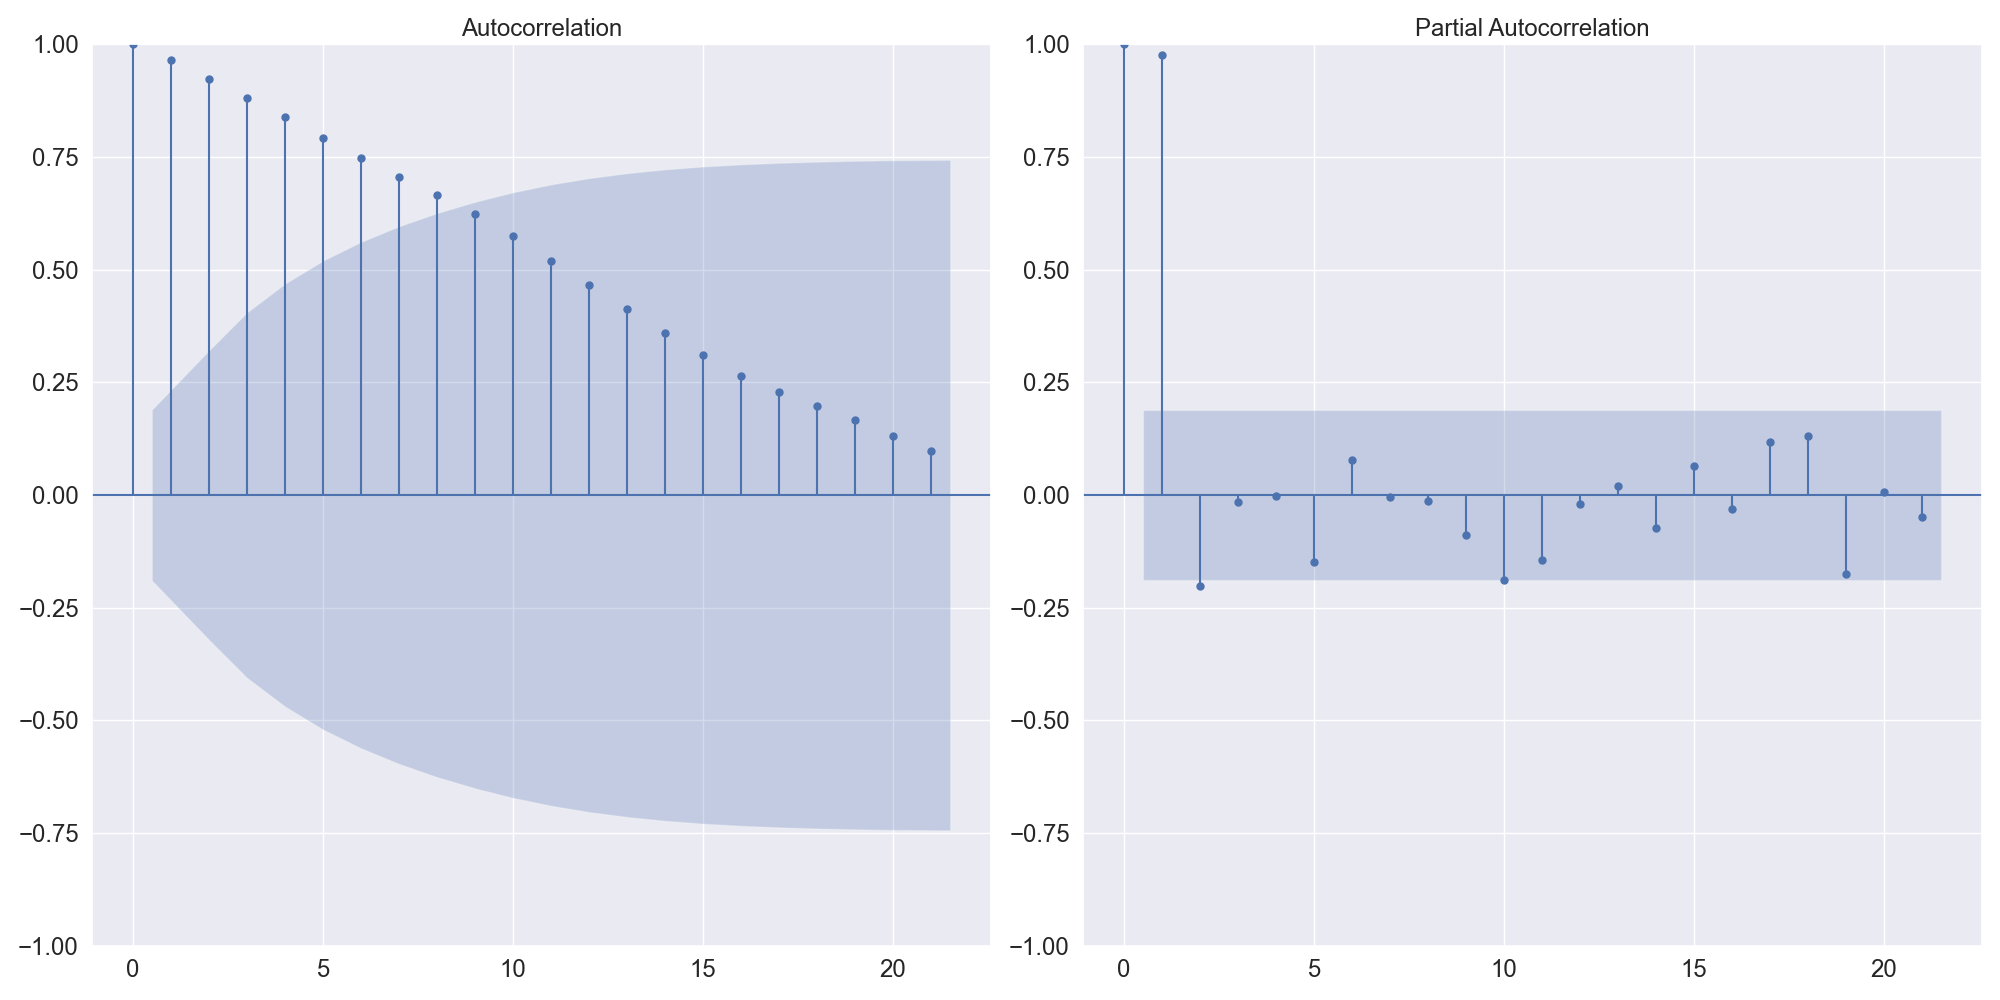
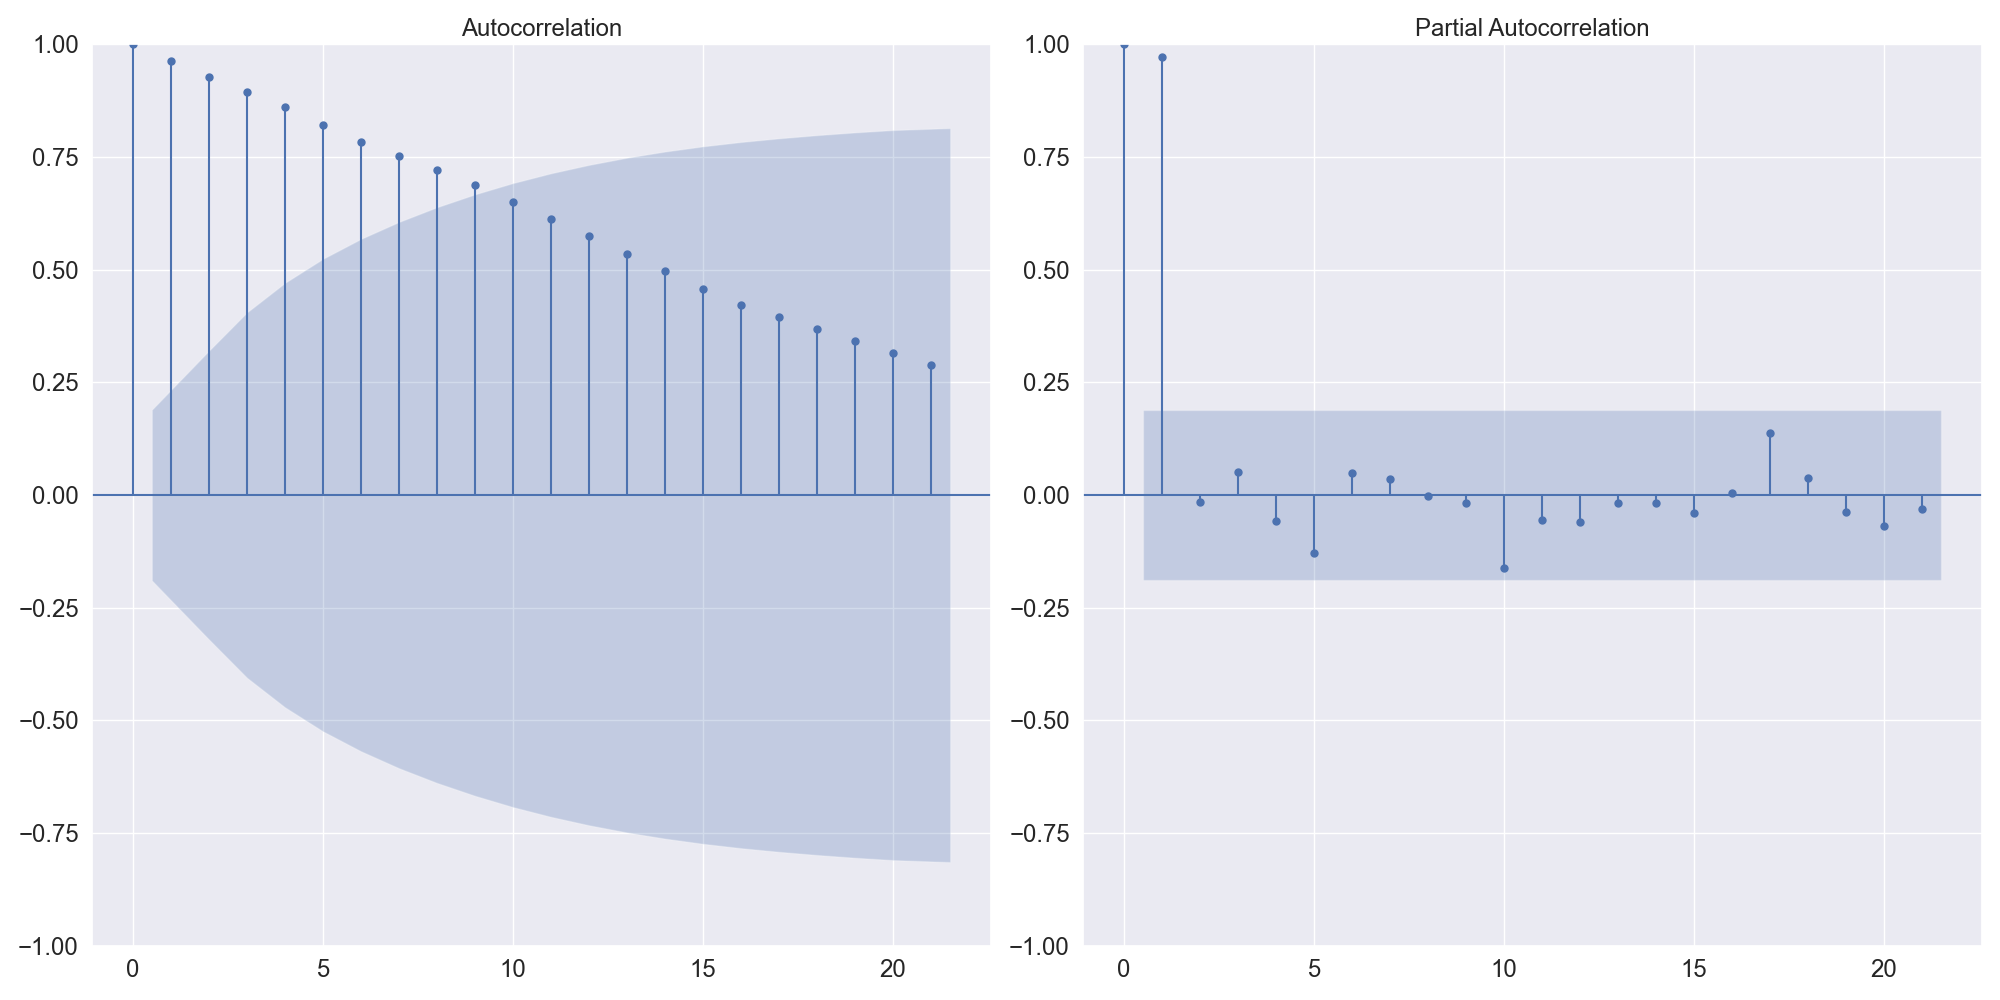
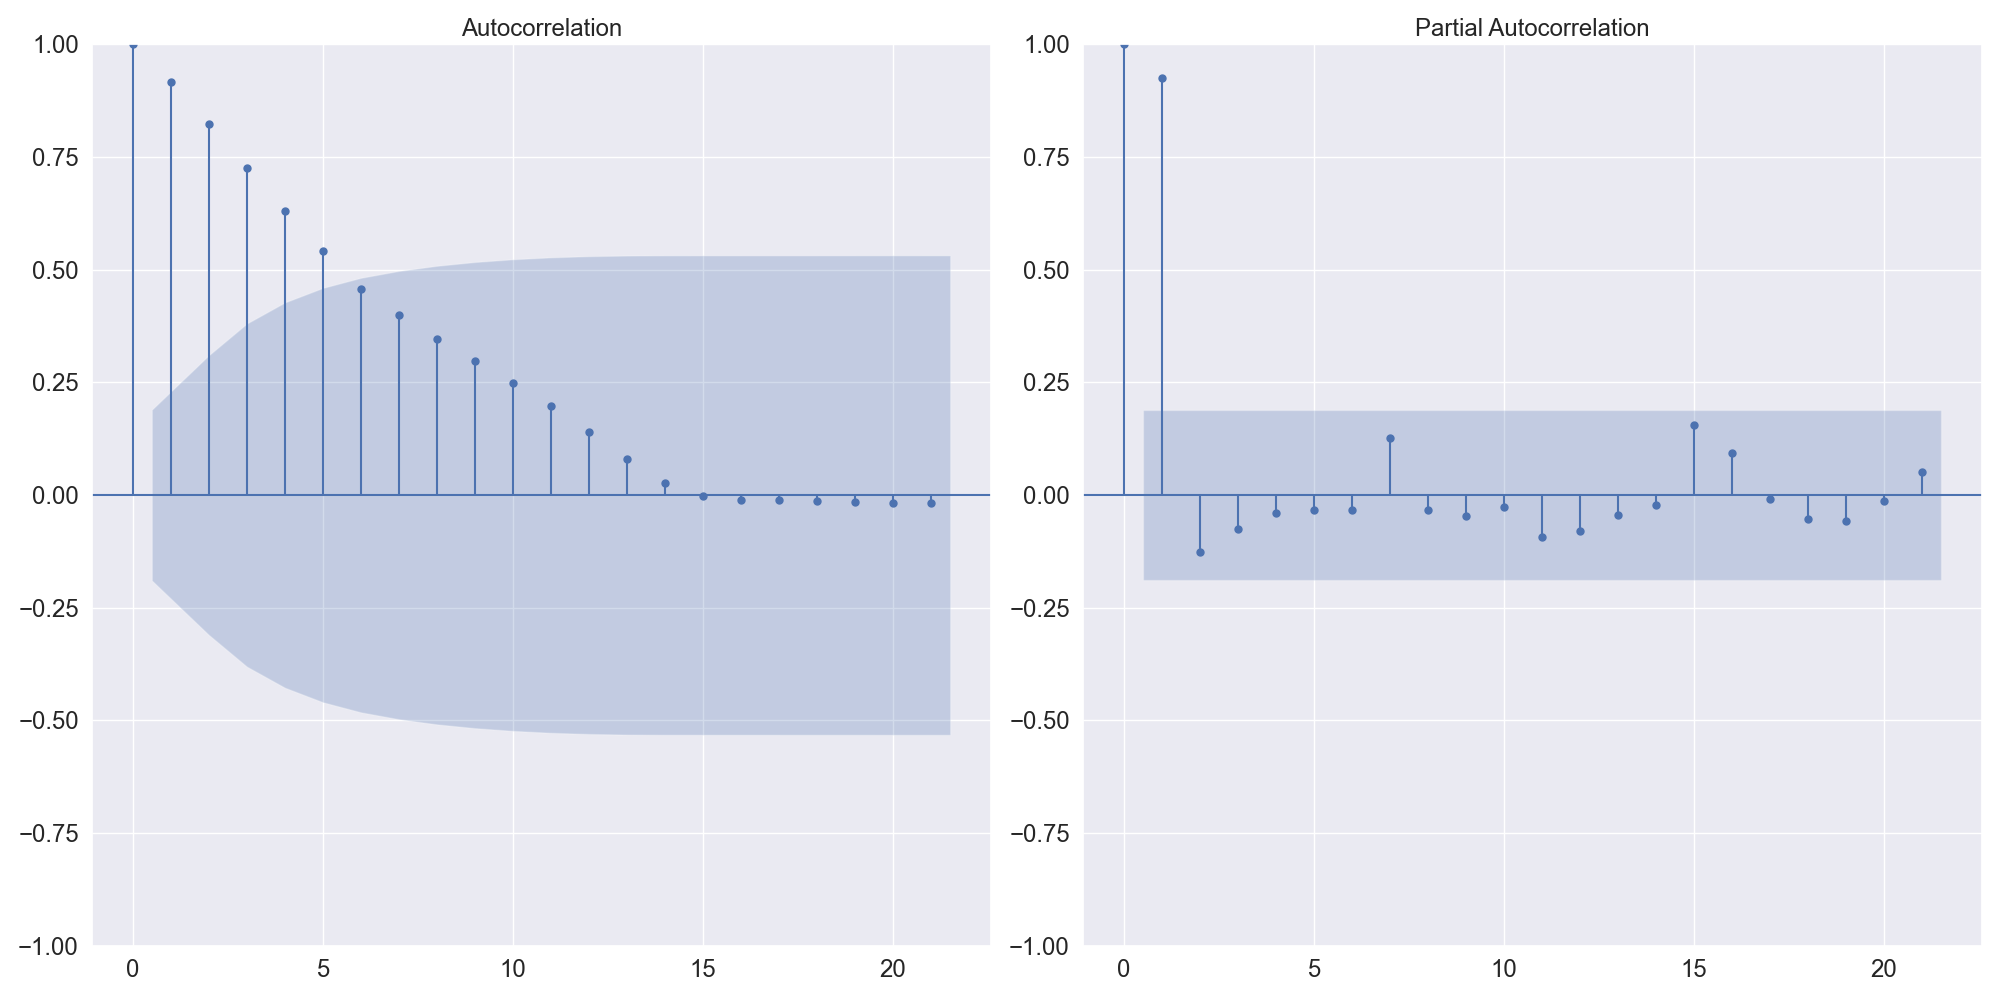

In [21]:
from validmind.model_validation.statsmodels.metrics import ACFandPACFFigures
test_context = TestContext(train_ds=vm_train_ds)
acf_pacf_metric = ACFandPACFFigures(test_context=test_context)
acf_pacf_metric.run()
acf_pacf_metric.result.show()

Automatic MA Order Identification using BIC and AIC.

In [22]:
from validmind.model_validation.statsmodels.metrics import AutoMA
test_context = TestContext(train_ds=vm_train_ds)
acf_pacf_metric = AutoMA(test_context=test_context)
acf_pacf_metric.run()

No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency 

No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency 

No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency 

No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency 

TestPlanMetricResult(figures=None, metric=MetricResult(type='evaluation', scope='test', key='auto_ma', value=[{'Variable': 'loan_rate_A', 'MA orders': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'BIC': [109.32983890924802, 51.50858998745842, 14.599332418398228, 7.843865675126803, 9.27676426175568, -1.1594667262722638, -5.042761151502113, -0.41631348947562685, -2.14140569353912, 0.6118886054824628], 'AIC': [101.31135240586231, 40.817274649610795, 1.2351882460886987, -8.19310733164463, -9.433037579477663, -22.54209740196751, -29.098220661659262, -27.144601834094686, -31.542522872620083, -31.462057408060403]}, {'Variable': 'loan_rate_B', 'MA orders': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'BIC': [169.27175747081606, 101.29421646338776, 68.49798955029898, 46.68171159677427, 44.1091720903092, 32.26048511954216, 28.953164988914207, 32.31259792260858, 36.856790706649825, 38.98315714037655], 'AIC': [161.25327096743032, 90.60290112554013, 55.13384537798945, 30.644738590002838, 25.399370249075858, 10.87785444384

**Step 4: Auto ARIMA**

**Step 5: Fit ARIMA Candidates**

In [15]:
vm.run_test_plan("normality_test_plan", train_ds=vm_train_ds, test_ds=vm_test_ds)

**Run `SeasonalDecomposeMetricWithFigure` Test**

In [16]:
test_context = TestContext(train_ds=vm_train_ds)
sd_metric = SeasonalDecomposeMetricWithFigure(test_context=test_context)
sd_metric.run()

TestPlanMetricResult(figures=[Figure(key='seasonal_decomposition_with_figure', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None)], metric=MetricResult(type='evaluation', scope='', key='seasonal_decomposition_with_figure', value={'loan_rate_A': [{'date': '2007-08-01', 'trend': nan, 'seasonal': -0.050284773390468294, 'resid': nan, 'observed': 7.7666666666666675}, {'date': '2007-09-01', 'trend': nan, 'seasonal': -0.06087962072801919, 'resid': nan, 'observed': 7.841428571428572}, {'date': '2007-10-01', 'trend': nan, 'seasonal': 0.01749661199350142, 'resid': nan, 'observed': 7.83}, {'date': '2007-11-01', 'trend': nan, 'seasonal': -0.047258378330469496, 'resid': nan, 'observed': 7.779090909090908}, {'date': '2007-12-01', 'trend': nan, 'seasonal': 0.0850517814632488, 'resid': nan, 'observed': 7.695833333333333}, {'date': '2008-01-01', 'trend': nan, 'seasonal': 0.06564185816692857, 'resid': nan, 'observed': 7.961333333333333}, {'date': '2008-02-01', 'trend': 8.0050487679590

**Run `ResidualsVisualInspection` Test**

In [17]:
test_context = TestContext(train_ds=vm_train_ds, test_ds=vm_test_ds)
rvi_test = ResidualsVisualInspection(test_context=test_context)
rvi_test.run()

TestPlanMetricResult(figures=[Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None)], metric=None)

In [18]:
vm.run_test_plan("seasonality_test_plan", train_ds=vm_train_ds, test_ds=vm_test_ds)

In [ ]:
vm.run_test_plan("timeseries_test_plan", test_ds=vm_test_ds, train_ds=vm_train_ds)